In [1]:
import numpy as np
import sympy as sp
from IPython.display import display, Math
from sympy import Symbol, symbols
from sympy import symbols, Abs
from sympy import *
from sympy.abc import *
import mpmath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import time
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib.animation as animation
import matplotlib.tri as mtri
from matplotlib.animation import FuncAnimation

size = 1000
acc = 256
mpmath.mp.dps = acc

In [2]:
EPS_ZERO = sp.Float('0', acc)
EPS_FLOAT = sp.Float('1.19209e-07', acc)
EPS_DOUBLE = sp.Float('2.22045e-16', acc)

PI = sp.Float(str(mpmath.pi), acc)
ONE = sp.Float(str(1), acc)
TWO = sp.Float(str(2), acc)
THREE = sp.Float(str(3), acc)
FOUR = sp.Float(str(4), acc)
SIX = sp.Float(str(6), acc)
EIGHT = sp.Float(str(8), acc)
NINE = sp.Float(str(9), acc)
ONE_HALF = sp.Float(Rational(1, 2), acc)
ONE_QUARTER = sp.Float(Rational(1, 4), acc)
ONE_THIRD = sp.Float(Rational(1, 3), acc)
ONE_SIXTH = sp.Float(Rational(1, 6), acc)
ONE_EIGHT = sp.Float(Rational(1, 8), acc)
ONE_NINTH = sp.Float(Rational(1, 9), acc)
ONE_16TH = sp.Float(Rational(1, 16), acc)
ONE_27TH = sp.Float(Rational(1, 27), acc)
ONE_64TH = sp.Float(Rational(1, 64), acc)
TWO_THIRD = sp.Float(Rational(2, 3), acc)
THREE_HALF = sp.Float(Rational(3, 2), acc)
FOUR_THIRD = sp.Float(Rational(4, 3), acc)
EIGHT_THIRD = sp.Float(Rational(8, 3), acc)
sqrt_3 = mpmath.sqrt(3)
SQRT_THREE_HALF = sp.Float(sqrt_3 * ONE_HALF, acc)
CLOSE_TO_ZERO = sp.Float(str(10), acc)**(-ONE_HALF * acc)

a = sp.parse_expr("a*(1 + epsilon_a)")
b = sp.parse_expr("b*(1 + epsilon_b)")
c = sp.parse_expr("c*(1 + epsilon_c)")
d = sp.parse_expr("d*(1 + epsilon_d)")

In [12]:
arg_pairs_mul = {}
arg_pairs_div = {}
arg_pairs_add = {}
arg_pairs_sub = {}
arg_pairs_fma = {}
arg_pairs_fms = {}
arg_pairs_sqrt = {}
arg_pairs_cbrt = {}

epsilon_mul = []
epsilon_div = []
epsilon_add = []
epsilon_sub = []
epsilon_fma = []
epsilon_fms = []
epsilon_sqrt = []
epsilon_cbrt = []
epsilon_vars = ['epsilon_a', 'epsilon_b', 'epsilon_c', 'epsilon_d']
epsilons = epsilon_vars

# Переопределение операции умножения: (a * b)(1 + eps_mul)
def mul(a, b):
    global arg_pairs_mul
    arg_pair = tuple(sorted([str(sp.Abs(a)), str(sp.Abs(b))]))
    
    if arg_pair not in arg_pairs_mul:
        arg_pairs_mul[arg_pair] = len(arg_pairs_mul) + 1
        epsilons.append(Symbol(f'epsilon_*{arg_pairs_mul[arg_pair]}'))
        epsilon_mul.append(Symbol(f'epsilon_*{arg_pairs_mul[arg_pair]}'))
        
    epsilon = Symbol(f'epsilon_*{arg_pairs_mul[arg_pair]}')
    return simplify_eps(a * b * (1 + epsilon))

# Переопределение операции деления: (a / b)(1 + eps_div)
def div(a, b):
    global arg_pairs_div
    arg_pair = tuple(sorted([str(sp.Abs(a)), str(sp.Abs(b))]))
    
    if arg_pair not in arg_pairs_div:
        arg_pairs_div[arg_pair] = len(arg_pairs_div) + 1
        epsilons.append(Symbol(f'epsilon_/{arg_pairs_div[arg_pair]}'))
        epsilon_div.append(Symbol(f'epsilon_/{arg_pairs_div[arg_pair]}'))
        
    epsilon = Symbol(f'epsilon_/{arg_pairs_div[arg_pair]}')
    return simplify_eps(a / b * (1 + epsilon))

# Переопределение операции суммы: (a + b)(1 + eps_add)
def add(a, b):
    global arg_pairs_add
    arg_pair = tuple(sorted([str(sp.Abs(a)), str(sp.Abs(b))]))
    
    if arg_pair not in arg_pairs_add:
        arg_pairs_add[arg_pair] = len(arg_pairs_add) + 1
        epsilons.append(Symbol(f'epsilon_+{arg_pairs_add[arg_pair]}'))
        epsilon_add.append(Symbol(f'epsilon_+{arg_pairs_add[arg_pair]}'))
        
    epsilon = Symbol(f'epsilon_+{arg_pairs_add[arg_pair]}')
    return simplify_eps((a + b) * (1 + epsilon))

# Переопределение операции вычитания: (a - b)(1 + eps_sub)
def sub(a, b):
    global arg_pairs_sub
    
    arg_pair = tuple(sorted([str(sp.Abs(a)), str(sp.Abs(b))]))
    
    if arg_pair not in arg_pairs_sub:
        arg_pairs_sub[arg_pair] = len(arg_pairs_sub) + 1
        epsilons.append(Symbol(f'epsilon_-{arg_pairs_sub[arg_pair]}'))
        epsilon_sub.append(Symbol(f'epsilon_-{arg_pairs_sub[arg_pair]}'))
        
    epsilon = Symbol(f'epsilon_-{arg_pairs_sub[arg_pair]}')
    return simplify_eps((a - b) * (1 + epsilon))

# Переопределение операции fma (a * b + c)(1 + eps_fma)
def fma(a, b, c):
    global arg_pairs_fma
    
    ab = sp.Abs(a*b)
    ab = simplify(ab, sort='a<b')
    
    arg_pair = tuple([str(ab), str(sp.Abs(c))])
    if arg_pair not in arg_pairs_fma:
        arg_pairs_fma[arg_pair] = len(arg_pairs_fma) + 1
        epsilons.append(Symbol(f'epsilon_fma{arg_pairs_fma[arg_pair]}'))
        epsilon_fma.append(Symbol(f'epsilon_fma{arg_pairs_fma[arg_pair]}'))
        
    return simplify_eps((simplify_eps(a * b) + c) * (1 + sp.Symbol(f'epsilon_fma{arg_pairs_fma[arg_pair]}')))

# Переопределение операции fms: (a * b - c * d)(1 + eps_fms)
def fms(a, b, c, d):
    global arg_pairs_fms
    
    ab = sp.Abs(a*b)
    cd = -sp.Abs(c*d)
    
    ab = simplify(ab, sort='a<b')
    cd = simplify(cd, sort='a<b')
    
    arg_pair = tuple(sorted([str(ab), str(cd)]))
    
    if arg_pair not in arg_pairs_fms:
        arg_pairs_fms[arg_pair] = len(arg_pairs_fms) + 1
        epsilons.append(Symbol(f'epsilon_fms{arg_pairs_fms[arg_pair]}'))
        epsilon_fms.append(Symbol(f'epsilon_fms{arg_pairs_fms[arg_pair]}'))
    
    return simplify_eps((simplify_eps(a * b) - simplify_eps(c * d)) * (1 + sp.Symbol(f'epsilon_fms{arg_pairs_fms[arg_pair]}')))

# Переопределение операции квадратного корня: sqrt(a)(1 + a/2 + eps_sqrt)
def Sqrt(a):
    global arg_pairs_sqrt
    TWO = sp.Float(2, acc)
    arg_pair = tuple(sorted(str(sp.Abs(a))))
    
    a_ = a.subs({s: 0 for s in epsilons})
    eps_expr = a - a_

    if arg_pair not in arg_pairs_sqrt:
        arg_pairs_sqrt[arg_pair] = len(arg_pairs_sqrt) + 1
        epsilons.append(Symbol(f'epsilon_sqrt{arg_pairs_sqrt[arg_pair]}'))
        epsilon_sqrt.append(Symbol(f'epsilon_sqrt{arg_pairs_sqrt[arg_pair]}'))
        
    epsilon = Symbol(f'epsilon_sqrt{arg_pairs_sqrt[arg_pair]}')
    #epsilon_ = Symbol(f'epsilon_expr{arg_pairs_sqrt[arg_pair]}')

    return simplify_eps(sqrt(a_) + a_ * eps_expr /(TWO * sqrt(a_)) + sqrt(a_)*epsilon)

# Переопределение операции кубического корня: cbrt(a)(1 + a/3 + eps_cbrt)
def Cbrt(a):
    global arg_pairs_cbrt
    arg_pair = tuple(sorted(str(sp.Abs(a))))
    
    a_ = a.subs({s: 0 for s in epsilons})
    eps_expr = a - a_

    if arg_pair not in arg_pairs_cbrt:
        arg_pairs_cbrt[arg_pair] = len(arg_pairs_cbrt) + 1
        epsilons.append(Symbol(f'epsilon_cbrt{arg_pairs_cbrt[arg_pair]}'))
        epsilon_cbrt.append(Symbol(f'epsilon_cbrt{arg_pairs_cbrt[arg_pair]}'))
        
    epsilon = Symbol(f'epsilon_cbrt{arg_pairs_cbrt[arg_pair]}')
    #epsilon_ = Symbol(f'epsilon_expr{arg_pairs_sqrt[arg_pair]}')
    cbrtA = sp.cbrt(a_)
    return cbrtA + a_ * eps_expr /(THREE * sp.cbrt(a_*a_)) + cbrtA*epsilon

In [5]:
# Метод упрощения выражения (epsilon порядка > 1 -> 0)
def simplify_eps(expr):
    expr = expand(expr)
    
    if not isinstance(expr, Expr):
        return expr
    
    # Проверяем содержит ли выражение перемножение epsilon-содержащих элементов
    if isinstance(expr, Mul):
        args = []
        for arg in expr.args:
            # Если аргумент - степень
            if arg.is_Pow:
                # Разбиваем его на основание и показатель степени
                base, exp = arg.as_base_exp() 
                # Если основание содержит подстроку'epsilon_' и показатель степени больше 1
                if str(base).startswith('epsilon_') and exp > 1:
                    # Заменяем аргумент на 0
                    arg = 0
                else:
                    # Рекурсивно упрощаем основание и показатель степени
                    arg = simplify_eps(base)**simplify_eps(exp)
            else:
                # Рекурсивно упрощаем аргумент
                arg = simplify_eps(arg)
            
            args.append(arg)
        
        new_args = []
        for i, arg1 in enumerate(args):
            for j in range(i + 1, len(args)):
                arg2 = args[j]
                # Если оба аргумента содержат подстроку 'epsilon_' (epsilon_1 * epsilon_2), то обращаем в 0
                if str(arg1).startswith('epsilon_') and str(arg2).startswith('epsilon_'):
                    # Добавляем 0 в новый список аргументов и прекращаем дальнейшую проверку
                    new_args.append(0)
                    break
            else:
                new_args.append(arg1)
        return Mul(*new_args)
    
    # Проверяем содержит ли выражение возведение в степень epsilon-содержащего элемента
    if isinstance(expr, Pow):
        # Разбиваем выражение на основание и показатель степени
        base, exp = expr.as_base_exp()
        # Если основание содержит подстроку'epsilon_' и показатель степени больше 1
        if str(base).startswith('epsilon_') and exp > 1:
            # Обращаем слагаемое в 0
            return 0
        else:
            # Рекурсивно упрощаем основание
            base = simplify_eps(base)
            # Рекурсивно упрощаем показатель степени
            exp = simplify_eps(exp)
            
            return Pow(base, exp)
    
    if isinstance(expr, Add):
        args = []
        for arg in expr.args:
            # Рекурсивно упрощаем аргумент
            arg = simplify_eps(arg)
            args.append(arg)
        return Add(*args)
    
    return expr

In [13]:
# Метод определения наихудшего случая
def abs_coeff_eps(expr):
    # Группируем коэффициенты относительно каждого epsilon-содержащего элемента
    expr = expr.expand()
    expr = expr.collect(epsilons)
    
    # Убираем все epsilon (epsilon_temp = 0)
    new_expr = expr.subs({s: 0 for s in epsilons})
    
    # Создаем словарь всех epsilon-содержащих элементов
    eps_syms = [symbol for symbol in epsilons if str(symbol) in [str(s) for s in expr.free_symbols]]
    
    for eps_sym in eps_syms:
        eps_sym = sp.Symbol(str(eps_sym))
        # Получаем коэффициент при eps_sym
        coeff = expr.coeff(eps_sym)
        # Задаем модуль полученного коэффициенты
        abs_coeff = Abs(coeff)
        # Добавляем перемножение eps_sym и модуля коэффициента, как слагаемое нового выражения
        new_expr += abs_coeff*eps_sym
            
    # Обработка случаев когда eps_syms = sqrt(epsilon_temp)
    for i in range(len(eps_syms)):
        eps_syms[i] = sp.Symbol(str(eps_syms[i]))**0.5

    for eps_sym in eps_syms:
        # Получаем коэффициент при eps_sym
        coeff = expr.coeff(eps_sym)
        # Задаем модуль полученного коэффициенты
        abs_coeff = Abs(coeff)
        # Добавляем перемножение eps_sym и модуля коэффициента, как слагаемое нового выражения
        new_expr += abs_coeff*eps_sym
    
    # Замена всех epsilon-содержащих элементов единой константой epsilon
    new_expr = new_expr.subs({s: epsilon for s in epsilons})
    
    return new_expr

In [16]:
abs_coeff_eps(mul(add(mul(Sqrt(a), b), c), d))

sqrt(a)*b*d + c*d + epsilon*Abs(c*d) + 3*epsilon*Abs(sqrt(a)*b*d) + 0.5*epsilon*Abs(a**(3/2)*b*d) + 3*epsilon*Abs(sqrt(a)*b*d + c*d)

In [26]:
def abs_coeff_eps1(expr):
    expr = expr.expand()
    expr = expr.collect(epsilons)

    eps_syms = [symbol for symbol in epsilons if str(symbol) in [str(s) for s in expr.free_symbols]]
    new_expr = expr
    
    for eps_sym in eps_syms:
        eps_sym = sp.Symbol(str(eps_sym))
        coeff = expr.coeff(eps_sym)
        abs_coeff = Abs(coeff)
        new_expr = new_expr.subs([(coeff*eps_sym, abs_coeff*eps_sym)])
        
    for i in range(len(eps_syms)):
        eps_syms[i] = sp.Symbol(str(eps_syms[i]))**0.5

    for eps_sym in eps_syms:
        coeff = expr.coeff(eps_sym)
        abs_coeff = Abs(coeff)
        new_expr = new_expr.subs([(coeff*eps_sym, abs_coeff*eps_sym)])
        
    return new_expr

In [6]:
def quartic(a, b, c, d, x):
    result = x**4+a*x**3+b*x**2+c*x+d
    
    return result

In [7]:
def generate(P, N, maxDistance):
    roots = np.zeros((N, P), dtype=object)
    coefficients = np.zeros((N, P), dtype=object)
    
    for i in range(N):
        mid = mpmath.rand() * sp.Float('2', acc) - sp.Float('1', acc)
        
        for j in range(P):    
            small = mpmath.rand() * sp.Float('2', acc) - sp.Float('1', acc)
            #small = mpmath.rand() * (sp.Float('2', acc) * maxDistance) - maxDistance
            roots[i][j] = small
            
        roots[i] = sorted(roots[i])
        coefficients[i][0] = -(roots[i][0] + roots[i][1] + roots[i][2] + roots[i][3])
        coefficients[i][1] = roots[i][0] * roots[i][1] + roots[i][0] * roots[i][2] + roots[i][0] * roots[i][3] + roots[i][1] * roots[i][2] + roots[i][1] * roots[i][3] + roots[i][2] * roots[i][3]
        coefficients[i][2] = -(roots[i][0] * roots[i][1] * roots[i][2] + roots[i][0] * roots[i][1] * roots[i][3] + roots[i][0] * roots[i][2] * roots[i][3] + roots[i][1] * roots[i][2] * roots[i][3])
        coefficients[i][3] = roots[i][0] * roots[i][1] * roots[i][2] * roots[i][3]


    return coefficients, roots

In [79]:
def quartic(A3, A2, A1, A0):
    a_ = -A2
    b_ = A1 * A3 - FOUR * A0
    c_ = FOUR * A0 * A2 - A1 * A1 - A0 * A3 * A3
    
    cRoots, num = cubic(a_, b_, c_)
    u1 = cRoots[num - 1]
    
    sigma = sign(A1 - A3 * u1 * ONE_HALF)
    
    p1 = A3 * ONE_HALF - sqrt(A3 * A3 * ONE_QUARTER + u1 - A2)
    p2 = A3 * ONE_HALF + sqrt(A3 * A3 * ONE_QUARTER + u1 - A2)
    q1 = u1 * ONE_HALF + sigma * sqrt(u1 * u1 * ONE_QUARTER - A0)
    q2 = u1 * ONE_HALF - sigma * sqrt(u1 * u1 * ONE_QUARTER - A0)
    
    Z1 = -p1 * ONE_HALF + sqrt(p1 * p1 * ONE_QUARTER - q1)
    Z2 = -p1 * ONE_HALF - sqrt(p1 * p1 * ONE_QUARTER - q1)
    Z3 = -p2 * ONE_HALF + sqrt(p2 * p2 * ONE_QUARTER - q2)
    Z4 = -p2 * ONE_HALF - sqrt(p2 * p2 * ONE_QUARTER - q2)
    
    return [Z1.evalf(acc), Z2.evalf(acc), Z3.evalf(acc), Z4.evalf(acc)]

In [8]:
def cubic(a2, a1, a0):
    Z = []
    
    A_THIRD = a2 * ONE_THIRD
    
    q = a1 * ONE_THIRD - a2 * a2 * ONE_NINTH
    r = (a1 * a2 - THREE * a0) * ONE_SIXTH - a2 * a2 * a2 * ONE_27TH

    D = r * r + q * q * q

    if D > 0:
        A = (abs(r) + sqrt(D))**(ONE_THIRD)
        t1 = A - q / A if r >= 0 else q / A - A

        Z1 = t1 - A_THIRD
        
        x2 = -t1 * ONE_HALF - A_THIRD
        x3 = x2
        
        y2 = SQRT_THREE_HALF * (A + q / A)
        y3 = -y2
        
        Z2 = x2 + sp.I * y2
        Z3 = x3 + sp.I * y3
        Z = [Z1, Z2, Z3]
        
        return Z, 1
    else:
        theta = 0 
        
        if q == 0:
            theta = 0
        elif q < 0:
            theta = mpmath.acos(r / (-q)**(THREE_HALF))
        else:
            return

        phi1 = theta * ONE_THIRD
        phi2 = phi1 - TWO_THIRD * PI 
        phi3 = phi1 + TWO_THIRD * PI 
        
        sqrtQ = TWO * mpmath.sqrt(-q)
        
        Z1 = sqrtQ * mpmath.cos(phi1) - A_THIRD
        Z2 = sqrtQ * mpmath.cos(phi2) - A_THIRD
        Z3 = sqrtQ * mpmath.cos(phi3) - A_THIRD
        
        Z = sorted([Z1, Z2, Z3])
        return Z, 3

In [21]:
def dscrmt(B, C):
    p = B * B
    q = C

    dp = B*B-p
    dq = C-q
    d = (p - q) + (dp - dq);
    
    return d

def Oldquadratic(b, c):
    b /= -TWO
    
    D = dscrmt(b, c)
    sqrtD = sqrt(D)
    
    bIsZero = 1 if b == 0 else 0
        
    S = b
    partS = sign(b) + bIsZero
    
    S = sqrtD * partS + S
    
    Z1 = sp.simplify(sp.expand_complex(S))
    Z2 = sp.simplify(sp.expand_complex(c / S))
    
    return Z1, Z2

def FMA(a, b, c):
    return a * b + c

def FMS(a, b, c, d):
    return a * b - c * d

def quadratic(b, c):
    D = b * b - FOUR * c
    
    sqrtD = sqrt(D)
    
    Z1 = sp.simplify(sp.expand_complex((-b + sqrtD) * ONE_HALF))
    Z2 = sp.simplify(sp.expand_complex((-b - sqrtD) * ONE_HALF))
    
    return Z1, Z2

def qdrTest(b, c, x):
    return sp.simplify(sp.expand(x**2 + b*x + c))

In [119]:
def read(coefficients, roots):
    coeffs_arr = []
    roots_arr = []
    croots_arr = []

    with open(coefficients, "r") as f:
        for line in f:
            values = line.split()
            coeffs_arr.append([float(x) for x in values])

    with open(roots, "r") as f:
        for line in f:
            values = line.split()
            roots_arr.append([float(x) for x in values])
    
    return coeffs_arr, roots_arr

In [50]:
def SquirePreprocess1(a3, a2, a1, a0, delta, p = sp.Symbol('p')):
    epsilon = sp.Symbol('epsilon')
    
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
    if exp < 1:
            epsilons.append(coeff)
    else:
        delta = simplify_eps(delta)
        if(delta != 0):
            epsilons.append(delta)
    
    coeff = []
    roots = []
    
    #коэффы ур-ия 6 степени 
    coeff.append(mul(mul(a0, a0), a0))
    coeff[0] = getCoeff(coeff[0], epsilon)
    
    coeff.append(-mul(mul(a2, a0), a0))
    coeff[1] = getCoeff(coeff[1], epsilon)
        
    coeff.append(mul(a0, fma(a1, a3, -a0)))
    coeff[2] = getCoeff(coeff[2], epsilon)
        
    coeff.append(fma(-a0, mul(a3, a3), fms(mul(TWO, a0), a2, a1, a1)))
    coeff[3] = getCoeff(coeff[3], epsilon)
        
    coeff.append(fma(a1, a3, -a0))
    coeff[4] = getCoeff(coeff[4], epsilon)

    coeff.append(-a2)
    coeff[5] = getCoeff(coeff[5], epsilon)

    #коэффы 2-х кв ур-й
    p = p * (1 + delta)
    p1 = div(a0, p)
    den = fma(p, p, -a0)
    q = div(mul(p, fma(a3, p, -a1)), den)
    q1 = div(fms(a1, p, a3, a0), den)

    quadCoeff = []
    quadCoeff.append(getCoeff(q, epsilon))
    quadCoeff.append(getCoeff(p, epsilon))
    quadCoeff.append(getCoeff(q1, epsilon))
    quadCoeff.append(getCoeff(p1, epsilon))
    
    return coeff, quadCoeff

#tmp1, tmp2 = SquirePreprocess(a, b, c, d, sp.sqrt(sp.Symbol('epsilon_p')))
#display(Math(sp.latex(tmp2[3])))

def getSquire(gamma):
    Z1, Z2, Z3, Z4 = Squire(gamma)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

def calcSquire1(ZN, coefficients, roots, eps, delta, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    
    sixCoeff, quadCoeff = SquirePreprocess1(a, b, c, d, delta)

    for i in range(6):
        sixCoeff[i] = sixCoeff[i].subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    for i in range(4):
        quadCoeff[i] = quadCoeff[i].subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
        
    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_p = sp.Symbol('p')
    l_q1 = sp.Symbol('q_1')
    l_q2 = sp.Symbol('q_2')
    l_q3 = sp.Symbol('q_3')
    l_q4 = sp.Symbol('q_4')

    lambdaZ1 = sp.lambdify((l_q1), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_q2), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_q3), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_q4), Z4, 'sympy')

    lambdaC1 = sp.lambdify((l_a, l_b, l_c, l_d), sixCoeff[0], 'sympy')
    lambdaC2 = sp.lambdify((l_a, l_b, l_c, l_d), sixCoeff[1], 'sympy')
    lambdaC3 = sp.lambdify((l_a, l_b, l_c, l_d), sixCoeff[2], 'sympy')
    lambdaC4 = sp.lambdify((l_a, l_b, l_c, l_d), sixCoeff[3], 'sympy')
    lambdaC5 = sp.lambdify((l_a, l_b, l_c, l_d), sixCoeff[4], 'sympy')
    lambdaC6 = sp.lambdify((l_a, l_b, l_c, l_d), sixCoeff[5], 'sympy')

    lambdaQ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_p), quadCoeff[0], 'sympy')
    lambdaQ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_p), quadCoeff[1], 'sympy')
    lambdaQ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_p), quadCoeff[2], 'sympy')
    lambdaQ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_p), quadCoeff[3], 'sympy')

    for i in range(N):
        print(i)
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        coeffC = []
        coeffC.append(lambdaC1(coeff[1], coeff[2], coeff[3], coeff[4]))
        coeffC.append(lambdaC2(coeff[1], coeff[2], coeff[3], coeff[4]))
        coeffC.append(lambdaC3(coeff[1], coeff[2], coeff[3], coeff[4]))
        coeffC.append(lambdaC4(coeff[1], coeff[2], coeff[3], coeff[4]))
        coeffC.append(lambdaC5(coeff[1], coeff[2], coeff[3], coeff[4]))
        coeffC.append(lambdaC6(coeff[1], coeff[2], coeff[3], coeff[4]))

        p = sp.Symbol('p')
        sixticEq = sp.Eq(p**6 + coeffC[5]*p**5 + coeffC[4]*p**4 + coeffC[3]*p**3 + coeffC[2]*p**2 + coeffC[1]*p + coeffC[0], 0)
        sixticRoots = list(sp.solveset(sixticEq, p))
        sixticRoot = sixticRoots[0].evalf(acc)
        
        coeffQ = []
        coeffQ.append(lambdaQ1(coeff[1], coeff[2], coeff[3], coeff[4], sixticRoot))
        coeffQ.append(lambdaQ2(coeff[1], coeff[2], coeff[3], coeff[4], sixticRoot))
        coeffQ.append(lambdaQ3(coeff[1], coeff[2], coeff[3], coeff[4], sixticRoot))
        coeffQ.append(lambdaQ4(coeff[1], coeff[2], coeff[3], coeff[4], sixticRoot))
        
        quadRoots1 = quadratic(coeffQ[0], coeffQ[1])
        quadRoots2 = quadratic(coeffQ[2], coeffQ[3])
        
        Z1_ = lambdaZ1(quadRoots1[0])
        Z2_ = lambdaZ2(quadRoots1[1])
        Z3_ = lambdaZ3(quadRoots2[0])
        Z4_ = lambdaZ4(quadRoots2[1])
        
        if(i == 3):
            display(Z1_)
            display(Z2_)
            display(Z3_)
            display(Z4_)
            
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])

        if(i==0):
            print(Z[0][0] - ROOTS[0][0])
            print(Z[0][1]- ROOTS[0][1])
            print(Z[0][2]- ROOTS[0][2])
            print(Z[0][3]- ROOTS[0][3])
            
    return Z

In [58]:
def calcFerrari(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_m = sp.Symbol('m')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_m), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_m), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_m), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_m), Z4, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        C = coeff[1] * ONE_QUARTER
        b2 = coeff[2] - SIX * C * C
        b1 = coeff[3] - TWO * coeff[2] * C + EIGHT * C * C * C
        b0 = coeff[4] - coeff[3] * C + coeff[2] * C * C - THREE * C * C * C * C

        a2 = b2
        a1 = b2 * b2 * ONE_QUARTER - b0
        a0 = -b1 * b1 * ONE_EIGHT

        mRoots, num = cubic(a2, a1, a0)
        
        m = mRoots[num - 1]

        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], m)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], m)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], m)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], m)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [12]:
def calcDescartes(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_y = sp.Symbol('y')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_y), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_y), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_y), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_y), Z4, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        C = coeff[1] * ONE_QUARTER
        b2 = coeff[2] - SIX * C * C
        b1 = coeff[3] - TWO * coeff[2] * C + EIGHT * C * C * C
        b0 = coeff[4] - coeff[3] * C + coeff[2] * C * C - THREE * C * C * C * C

        a2 = TWO * b2
        a1 = b2 * b2 - FOUR * b0
        a0 = -b1 * b1

        yyRoots, num = cubic(a2, a1, a0)
        
        y = sqrt(yyRoots[num - 1]) if yyRoots[num - 1] > 0 else sp.Float('0', acc)

        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], y)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], y)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], y)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], y)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [13]:
def calcNBS(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_u = sp.Symbol('u')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_u), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_u), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_u), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_u), Z4, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc), #A3-1
                sp.Float(str(coefficients[i][1]), acc), #A2-2
                sp.Float(str(coefficients[i][2]), acc), #A1-3
                sp.Float(str(coefficients[i][3]), acc)] #A0-4
        
        a2 = -coeff[2] 
        a1 = coeff[1] * coeff[3] - FOUR * coeff[4]
        a0 = FOUR * coeff[4] * coeff[2] - coeff[3] * coeff[3] - coeff[4] * coeff[1] * coeff[1]

        uRoots, num = cubic(a2, a1, a0)
        
        u = uRoots[num - 1]

        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], u)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], u)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], u)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], u)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [14]:
def calcEuler(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_r1 = sp.Symbol('r_1')
    l_x2 = sp.Symbol('x_2')
    l_x3 = sp.Symbol('x_3')
    l_y2 = sp.Symbol('y_2')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_r1, l_x2, l_x3, l_y2), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_r1, l_x2, l_x3, l_y2), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_r1, l_x2, l_x3, l_y2), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_r1, l_x2, l_x3, l_y2), Z4, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        C = coeff[1] * ONE_QUARTER
        b2 = coeff[2] - SIX * C * C
        b1 = coeff[3] - TWO * coeff[2] * C + EIGHT * C * C * C
        b0 = coeff[4] - coeff[3] * C + coeff[2] * C * C - THREE * C * C * C * C

        a2 = ONE_HALF * b2
        a1 = (b2 * b2 - FOUR * b0) * ONE_16TH
        a0 = -b1 * b1 * ONE_64TH

        rRoots, num = cubic(a2, a1, a0)
        
        if(num == 1):
            r1 = rRoots[0]
            x2 = re(rRoots[1])
            x3 = re(rRoots[2])
            y2 = im(rRoots[1])
        else:
            r1 = rRoots[2]
            x2 = re(rRoots[0])
            x3 = re(rRoots[1])
            y2 = im(rRoots[0])

        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [15]:
def calcVanDerWaerden(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_theta1 = sp.Symbol('theta_1')
    l_x2 = sp.Symbol('theta_x_2')
    l_x3 = sp.Symbol('theta_x_3')
    l_y2 = sp.Symbol('theta_y_2')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_theta1, l_x2, l_x3, l_y2), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_theta1, l_x2, l_x3, l_y2), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_theta1, l_x2, l_x3, l_y2), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_theta1, l_x2, l_x3, l_y2), Z4, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        C = coeff[1] * ONE_QUARTER
        b2 = coeff[2] - SIX * C * C
        b1 = coeff[3] - TWO * coeff[2] * C + EIGHT * C * C * C
        b0 = coeff[4] - coeff[3] * C + coeff[2] * C * C - THREE * C * C * C * C

        a2 = -TWO * b2
        a1 = b2 * b2 - FOUR * b0
        a0 = b1 * b1

        rRoots, num = cubic(a2, a1, a0)
        
        if(num == 1):
            r1 = rRoots[0]
            x2 = re(rRoots[1])
            x3 = re(rRoots[2])
            y2 = im(rRoots[1])
        else:
            r1 = rRoots[2]
            x2 = re(rRoots[0])
            x3 = re(rRoots[1])
            y2 = im(rRoots[0])

        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], r1, x2, x3, y2)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [16]:
def calcTschirnhaus(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_f = sp.Symbol('f')
    l_q1 = sp.Symbol('q_1')
    l_q2 = sp.Symbol('q_2')
    l_q3 = sp.Symbol('q_3')
    l_q4 = sp.Symbol('q_4')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_f, l_q1), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_f, l_q2), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_f, l_q3), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_f, l_q4), Z4, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        C = coeff[1] * ONE_QUARTER
        b2 = coeff[2] - SIX * C * C
        b1 = coeff[3] - TWO * coeff[2] * C + EIGHT * C * C * C
        b0 = coeff[4] - coeff[3] * C + coeff[2] * C * C - THREE * C * C * C * C

        a2 = b2 * ONE_HALF
        a1 = -b0
        a0 = (b1 * b1 - FOUR * b2 * b0) * ONE_EIGHT
        
        fRoots, num = cubic(a2, a1, a0)
        
        ff = fRoots[num - 1]
        f = sqrt(ff)
        
        k = TWO * ff + b2
        sqrtK = sqrt(-k)
        
        #первая пара
        c1 = TWO * f - sqrtK
        c0 = sqrtK * (f * k + ONE_HALF * b1) / k
        q1, q2 = quadratic(c1, -c0)

        #вторая пара
        c1 = TWO * f + sqrtK
        q3, q4 = quadratic(c1, c0)

        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], f, q1)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], f, q2)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], f, q3)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], f, q4)
        
        if(i == 3):
            display(Z1_)
            display(Z2_)
            display(Z3_)
            display(Z4_)
            
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [ ]:
def calcSquire(ZN, coefficients, roots, eps, delta, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
        
    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_q1 = sp.Symbol('q_1')
    l_q2 = sp.Symbol('q_2')
    l_q3 = sp.Symbol('q_3')
    l_q4 = sp.Symbol('q_4')

    lambdaZ1 = sp.lambdify((l_q1), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_q2), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_q3), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_q4), Z4, 'sympy')

    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]

        coeffC = []
        roots = []

        #коэффы ур-ия 6 степени 
        coeffC.append(coeff[4] * coeff[4] * coeff[4])
        coeffC.append(-coeff[2] * coeff[4] * coeff[4])
        coeffC.append(coeff[4] * FMA(coeff[3], coeff[1], -coeff[4]))
        coeffC.append(FMA(-coeff[4], coeff[1] * coeff[1], FMS(TWO * coeff[4], coeff[2], coeff[3], coeff[3])))
        coeffC.append(FMA(coeff[3], coeff[1], -coeff[4]))
        coeffC.append(-coeff[2])
    
        p = sp.Symbol('p')
        sixticEq = sp.Eq(p**6 + coeffC[5]*p**5 + coeffC[4]*p**4 + coeffC[3]*p**3 + coeffC[2]*p**2 + coeffC[1]*p + coeffC[0], 0)
        sixticRoots = list(sp.solveset(sixticEq, p))
        sixticRoot = sixticRoots[0].evalf(acc)
        
        #коэффы 2-х кв ур-й
        p = sixticRoot * (1 + delta)
        p1 = coeff[4] / p
        den = FMA(p, p, -coeff[4])
        q = p * FMA(coeff[1], p, -coeff[3]) / den
        q1 = FMS(coeff[3], p, coeff[1], coeff[4]) / den
    
        coeffQ = []
        coeffQ.append(q)
        coeffQ.append(p)
        coeffQ.append(q1)
        coeffQ.append(p1)
        
        quadRoots1 = quadratic(coeffQ[0], coeffQ[1])
        quadRoots2 = quadratic(coeffQ[2], coeffQ[3])
        
        Z1_ = lambdaZ1(quadRoots1[0])
        Z2_ = lambdaZ2(quadRoots1[1])
        Z3_ = lambdaZ3(quadRoots2[0])
        Z4_ = lambdaZ4(quadRoots2[1])
        
        if(i == 3):
            display(Z1_)
            display(Z2_)
            display(Z3_)
            display(Z4_)
            
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [ ]:
def calcFQS(coefficients, roots, eps, delta, N):
    Z = []
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        Z1, Z2, Z3, Z4 = FQS(coeff[1], coeff[2], coeff[3], coeff[4], eps, delta)
        
        Z1 = Z1 if sp.im(Z1) == 0 else np.inf
        Z2 = Z2 if sp.im(Z2) == 0 else np.inf
        Z3 = Z3 if sp.im(Z3) == 0 else np.inf
        Z4 = Z4 if sp.im(Z4) == 0 else np.inf
        
        values = sorted([Z1, Z2, Z3, Z4])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [213]:
def calcMerriman(ZN, coefficients, roots, eps, sz):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    Z1 = Z1.subs(sp.Symbol('epsilon'), eps)
    Z2 = Z2.subs(sp.Symbol('epsilon'), eps)
    Z3 = Z3.subs(sp.Symbol('epsilon'), eps)
    Z4 = Z4.subs(sp.Symbol('epsilon'), eps)

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_m = sp.Symbol('m')
    l_n = sp.Symbol('n')
    l_s = sp.Symbol('Sigma')
    
    M, N = MerrimanPreprocessor(a, b, c, d, eps)
    M = M.subs(sp.Symbol('epsilon'), eps)
    N = N.subs(sp.Symbol('epsilon'), eps)
    
    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_m, l_n, l_s), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_m, l_n, l_s), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_m, l_n, l_s), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_m, l_n, l_s), Z4, 'sympy')
    
    lambdaM = sp.lambdify((l_a, l_b, l_c, l_d), M, 'sympy')
    lambdaN = sp.lambdify((l_a, l_b, l_c, l_d), N, 'sympy')
    
    for i in range(sz):
        print(i)
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        m = lambdaM(coeff[1], coeff[2], coeff[3], coeff[4])
        n = lambdaN(coeff[1], coeff[2], coeff[3], coeff[4])
        
        if(m*m-n < 0):
            Z.append([np.inf, np.inf, np.inf, np.inf])
            continue
        
        sigma = sp.Float('-1', acc) if m - sqrt(m * m - n) < 0 else sp.Float('1', acc)
        
        Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], m, n, sigma)
        Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], m, n, sigma)
        Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], m, n, sigma)
        Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], m, n, sigma)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [ ]:
def calcSalzer(ZN, ZN1, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]
    Z1_1, Z2_1, Z3_1, Z4_1 = ZN1[0], ZN1[1], ZN1[2], ZN1[3]
    
    Z1 = Z1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2 = Z2.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3 = Z3.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4 = Z4.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    
    Z1_1 = Z1_1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z2_1 = Z2_1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z3_1 = Z3_1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))
    Z4_1 = Z4_1.subs(sp.Symbol('epsilon'), sp.Float(str(eps), acc))

    l_a = sp.Symbol('a')
    l_b = sp.Symbol('b')
    l_c = sp.Symbol('c')
    l_d = sp.Symbol('d')
    l_x = sp.Symbol('x')

    lambdaZ1 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z4, 'sympy')
    
    lambdaZ1_1 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z1_1, 'sympy')
    lambdaZ2_1 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z2_1, 'sympy')
    lambdaZ3_1 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z3_1, 'sympy')
    lambdaZ4_1 = sp.lambdify((l_a, l_b, l_c, l_d, l_x), Z4_1, 'sympy')
    
    for i in range(N):
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc), #A - 1
                sp.Float(str(coefficients[i][1]), acc), #B - 2
                sp.Float(str(coefficients[i][2]), acc), #C - 3
                sp.Float(str(coefficients[i][3]), acc)] #D - 4

        a2 = -coeff[2]
        a1 = FMS(coeff[1], coeff[3], FOUR, coeff[4])
        a0 = FMS(coeff[4], FMS(FOUR, coeff[2], coeff[1], coeff[1]), coeff[3], coeff[3])

        xRoots, num = cubic(a2, a1, a0)
        
        x = xRoots[num - 1]

        MM = FMA(ONE_QUARTER * coeff[1], coeff[1], -coeff[2]) + x
        #m, n, m1, n1 = SalzerPreprocess(a, b, c, d, sp.parse_expr("x * (1 + sqrt(epsilon_x))"))

        if (MM == 0):
            print("gg wp")
            Z1_ = lambdaZ1_1(coeff[1], coeff[2], coeff[3], coeff[4], x)
            Z2_ = lambdaZ2_1(coeff[1], coeff[2], coeff[3], coeff[4], x)
            Z3_ = lambdaZ3_1(coeff[1], coeff[2], coeff[3], coeff[4], x)
            Z4_ = lambdaZ4_1(coeff[1], coeff[2], coeff[3], coeff[4], x)
        else:
            Z1_ = lambdaZ1(coeff[1], coeff[2], coeff[3], coeff[4], x)
            Z2_ = lambdaZ2(coeff[1], coeff[2], coeff[3], coeff[4], x)
            Z3_ = lambdaZ3(coeff[1], coeff[2], coeff[3], coeff[4], x)
            Z4_ = lambdaZ4(coeff[1], coeff[2], coeff[3], coeff[4], x)

        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])
            
    return Z

In [7]:
def calcDepressed(A3, A2, A1, A0):
    C = mul(A3, ONE_QUARTER)
    b2 = sub(A2, mul(mul(SIX, C), C))
    b1 = add(sub(A1, mul(mul(TWO, A2), C)), mul(mul(mul(EIGHT, C), C), C))
    b0 = sub(add(sub(A0, mul(A1, C)), mul(mul(A2, C), C)), mul(mul(mul(mul(THREE, C), C), C), C))
    
    return b2, b1, b0

def FerrariPreprocessor(A3, A2, A1, A0):
    b2, b1, b0 = calcDepressed(A3, A2, A1, A0)
    epsilon = sp.Symbol('epsilon')
    a2 = getCoeff(b2, EPS_FLOAT)
    a1 = getCoeff(sub(mul(mul(b2, b2), ONE_QUARTER), b0), EPS_FLOAT)
    a0 = getCoeff(-mul(mul(b1, b1), ONE_EIGHT), EPS_FLOAT)
    
    return [a2, a1, a0]

In [18]:
def Ferrari(A3, A2, A1, A0, delta = sp.Symbol('delta'), m = sp.Symbol('m')):
    ONE_HALF = sp.Float(Rational(1, 2), acc)
    ONE_QUARTER = sp.Float(Rational(1, 4), acc)
    ONE = sp.Float(str(1), acc)
    TWO = sp.Float(str(2), acc)
    THREE = sp.Float(str(3), acc)
    SIX = sp.Float(str(6), acc)
    EIGHT = sp.Float(str(8), acc)
    
    C = mul(A3, ONE_QUARTER)
    b2 = sub(A2, mul(mul(SIX, C), C))
    b1 = add(sub(A1, mul(mul(TWO, A2), C)), mul(mul(mul(EIGHT, C), C), C))
    b0 = sub(add(sub(A0, mul(A1, C)), mul(mul(A2, C), C)), mul(mul(mul(mul(THREE, C), C), C), C))
    
    m = m * (1 + delta)
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            delta = simplify_eps(delta)
            if(delta != 0):
                epsilons.append(delta)
        
    sigma = sign(b1)
    if(b1 == 0):
        sigma = -ONE

    R = mul(sigma, Sqrt(sub(add(add(mul(m, m), mul(b2, m)), mul(ONE_QUARTER, mul(b2, b2))), b0)))

    mHalf = mul(m, ONE_HALF)
    sqrtMHalf = Sqrt(mHalf)
    b2Half = mul(b2, ONE_HALF)
    
    radicandPart = sub(-mHalf, b2Half)
    radical1 = Sqrt(sub(radicandPart, R))
    radical2 = Sqrt(add(radicandPart, R))
    
    rootPart1 = sub(sqrtMHalf, C)
    rootPart2 = sub(-sqrtMHalf, C)

    Z1 = add(rootPart1, radical1)
    Z2 = sub(rootPart1, radical1)
    Z3 = add(rootPart2, radical2)
    Z4 = sub(rootPart2, radical2)
    
    return Z1, Z2, Z3, Z4

In [19]:
def Descartes (A3, A2, A1, A0, delta = sp.Symbol('delta'), yy = sp.Symbol('y')**2):
    C = mul(A3, ONE_QUARTER)
    b2 = sub(A2, mul(mul(SIX, C), C))
    b1 = add(sub(A1, mul(mul(TWO, A2), C)), mul(mul(mul(EIGHT, C), C), C))
    b0 = sub(add(sub(A0, mul(A1, C)), mul(mul(A2, C), C)), mul(mul(mul(mul(THREE, C), C), C), C))
    
    yy = yy * (1 + delta)
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            delta = simplify_eps(delta)
            if(delta != 0):
                epsilons.append(delta)
        
    sigma = sign(b1)
    if(b1 == 0):
        sigma = -1
    
    R = mul(sigma, Sqrt(sub(add(add(mul(mul(yy, yy), ONE_QUARTER), mul(mul(b2, ONE_HALF), yy)), mul(mul(b2, b2), ONE_QUARTER)), b0)))
    
    y = Sqrt(yy)
    
    yHalf = mul(y, ONE_HALF)
    b2Half = mul(b2, ONE_HALF)
    yyQuarter = mul(-yy, ONE_QUARTER)
    
    radicandPart = sub(yyQuarter, b2Half)
    radical1 = Sqrt(sub(radicandPart, R))
    radical2 = Sqrt(add(radicandPart, R))
    
    rootPart1 = sub(yHalf, C)
    rootPart2 = -add(yHalf, C)
    
    Z1 = add(rootPart1, radical1)
    Z2 = sub(rootPart1, radical1)
    Z3 = add(rootPart2, radical2)
    Z4 = sub(rootPart2, radical2)
    
    return Z1, Z2, Z3, Z4

In [20]:
def NBS(A3, A2, A1, A0, delta = sp.Symbol('delta'), u = sp.Symbol('u')):
    u = u * (1 + delta)
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            delta = simplify_eps(delta)
            if(delta != 0):
                epsilons.append(delta)
        
    sigma = sign(A1 - A3 * u * ONE_HALF)
    if(A1 - A3 * u * ONE_HALF == 0):
        sigma = -1
    
    A3Half = mul(A3, ONE_HALF)
    AA3Quarter = mul(mul(A3, A3), ONE_QUARTER)
    radicalP = Sqrt(sub(add(AA3Quarter, u), A2))
    
    uHalf = mul(u, ONE_HALF)
    uuQuarter = mul(mul(u, u), ONE_QUARTER)
    radicalQ = mul(sigma, Sqrt(sub(uuQuarter, A0)))
    
    p1 = sub(A3Half, radicalP)
    p2 = add(A3Half, radicalP)
    q1 = add(uHalf, radicalQ)
    q2 = sub(uHalf, radicalQ)
    
    p1Half = mul(p1, -ONE_HALF)
    pp1Quarter = mul(mul(p1, p1), ONE_QUARTER)
    p2Half = mul(p2, -ONE_HALF)
    pp2Quarter = mul(mul(p2, p2), ONE_QUARTER)
    
    radical1 = Sqrt(sub(pp1Quarter, q1))
    radical2 = Sqrt(sub(pp2Quarter, q2))
    
    Z1 = add(p1Half, radical1)
    Z2 = sub(p1Half, radical1)
    Z3 = add(p2Half, radical2)
    Z4 = sub(p2Half, radical2)
    
    return Z1, Z2, Z3, Z4

In [21]:
def Euler (A3, A2, A1, A0, delta):
    C = mul(A3, ONE_QUARTER)
    b2 = sub(A2, mul(mul(SIX, C), C))
    b1 = add(sub(A1, mul(mul(TWO, A2), C)), mul(mul(mul(EIGHT, C), C), C))
    b0 = sub(add(sub(A0, mul(A1, C)), mul(mul(A2, C), C)), mul(mul(mul(mul(THREE, C), C), C), C))
    
    for i in range(4):
        if 'epsilon' in str(delta[i]):
            coeff, exp = delta[i].as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            delta[i] = simplify_eps(delta[i])
            if(delta[i] != 0):
                epsilons.append(delta[i])
    
    r1 = sp.Symbol('r_1') * (1 + delta[0])
    x2 = sp.Symbol('x_2') * (1 + delta[1])
    x3 = sp.Symbol('x_3') * (1 + delta[2])
    y2 = sp.Symbol('y_2') * (1 + delta[3])
    
    sigma = sign(b1)
    if(b1 == 0):
        sigma = -1

    subradical = mul(TWO, mul(sigma, Sqrt(add(mul(x2, x3), mul(y2, y2)))))
    sumX = add(x2, x3)
    sqrtR1 = Sqrt(r1)
    
    radical1 = Sqrt(sub(sumX, subradical))
    radical2 = Sqrt(add(sumX, subradical))
    
    Z1 = sub(add(sqrtR1, radical1), C)
    Z2 = sub(sub(sqrtR1, radical1), C)
    Z3 = sub(add(-sqrtR1, radical2), C)
    Z4 = sub(sub(-sqrtR1, radical2), C)
    
    return Z1, Z2, Z3, Z4

In [22]:
def VanDerWaerden(A3, A2, A1, A0, delta):
    C = mul(A3, ONE_QUARTER)
    b2 = sub(A2, mul(mul(SIX, C), C))
    b1 = add(sub(A1, mul(mul(TWO, A2), C)), mul(mul(mul(EIGHT, C), C), C))
    b0 = sub(add(sub(A0, mul(A1, C)), mul(mul(A2, C), C)), mul(mul(mul(mul(THREE, C), C), C), C))
    
    for i in range(4):
        if 'epsilon' in str(delta[i]):
            coeff, exp = delta[i].as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            delta[i] = simplify_eps(delta[i])
            if(delta[i] != 0):
                epsilons.append(delta[i])
    
    theta1 = sp.Symbol('theta_1') * (1 + delta[0])
    x2 = sp.Symbol('theta_x_2') * (1 + delta[1])
    x3 = sp.Symbol('theta_x_3') * (1 + delta[2])
    y2 = sp.Symbol('theta_y_2') * (1 + delta[3])
    
    sigma = sign(b1)
    if(b1 == 0):
        sigma = -1

    subradical = mul(TWO, mul(sigma, Sqrt(add(mul(x2, x3), mul(y2, y2)))))
    subX = sub(-x2, x3)
    sqrtTheta1 = Sqrt(-theta1)
    
    radical1 = Sqrt(sub(subX, subradical))
    radical2 = Sqrt(add(subX, subradical))
    
    Z1 = sub(mul(ONE_HALF, add(sqrtTheta1, radical1)), C)
    Z2 = sub(mul(ONE_HALF, sub(sqrtTheta1, radical1)), C)
    Z3 = sub(mul(ONE_HALF, add(-sqrtTheta1, radical2)), C)
    Z4 = sub(mul(ONE_HALF, sub(-sqrtTheta1, radical2)), C)
    
    return Z1, Z2, Z3, Z4

In [23]:
def Tschirnhaus(A3, A2, A1, A0, delta, gamma, ff = sp.Symbol('f')**2):
    C = mul(A3, ONE_QUARTER)
    b2 = sub(A2, mul(mul(SIX, C), C))
    b1 = add(sub(A1, mul(mul(TWO, A2), C)), mul(mul(mul(EIGHT, C), C), C))
    b0 = sub(add(sub(A0, mul(A1, C)), mul(mul(A2, C), C)), mul(mul(mul(mul(THREE, C), C), C), C))
                
    ff = ff * (1 + delta)
    
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
    if exp < 1:
            epsilons.append(coeff)
    else:
        delta = simplify_eps(delta)
        if(delta != 0):
            epsilons.append(delta)
            
    f = Sqrt(ff)
    
    for i in range(4):
        if 'epsilon' in str(gamma[i]):
            coeff, exp = gamma[i].as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            gamma[i] = simplify_eps(gamma[i])
            if(gamma[i] != 0):
                epsilons.append(gamma[i])
                
    q1 = sp.Symbol('q_1') * (1 + gamma[0])
    q2 = sp.Symbol('q_2') * (1 + gamma[1])
    q3 = sp.Symbol('q_3') * (1 + gamma[2])
    q4 = sp.Symbol('q_4') * (1 + gamma[3])
    
    rootPart = sub(f, C)
    
    Z1 = add(q1, rootPart)
    Z2 = add(q2, rootPart)
    Z3 = add(q3, rootPart)
    Z4 = add(q4, rootPart)
    
    return Z1, Z2, Z3, Z4

In [ ]:
def Salzer(A, B, C, D, deltaX, m, n, x = sp.Symbol('x')):
    if 'epsilon' in str(deltaX):
        coeff, exp = deltaX.as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            deltaX = simplify_eps(deltaX)
            if(deltaX != 0):
                epsilons.append(deltaX)
                
    x = x * (1 + deltaX)
    
    alpha = sub(fma(mul(ONE_HALF, A), A, -x), B)
    beta = fms(FOUR, n, A, m)
    gamma = Sqrt(add(alpha, beta))
    delta = Sqrt(sub(alpha, beta))
    rootPart1 = fms(ONE_HALF, m, ONE_QUARTER, A)
    rootPart2 = fms(-ONE_HALF, m, ONE_QUARTER, A)
    halfGamma = mul(ONE_HALF, gamma)
    halfDelta = mul(ONE_HALF, delta)

    Z1 = add(halfGamma, rootPart1)
    Z2 = add(-halfGamma, rootPart1)
    Z3 = add(halfDelta, rootPart2)
    Z4 = add(-halfDelta, rootPart2)
    
    return Z1, Z2, Z3, Z4

In [ ]:
def Squire(gamma):
    for i in range(4):
        if 'epsilon' in str(gamma[i]):
            coeff, exp = gamma[i].as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            gamma[i] = simplify_eps(gamma[i])
            if(gamma[i] != 0):
                epsilons.append(gamma[i])
                
    q1 = sp.Symbol('q_1') * (1 + gamma[0])
    q2 = sp.Symbol('q_2') * (1 + gamma[1])
    q3 = sp.Symbol('q_3') * (1 + gamma[2])
    q4 = sp.Symbol('q_4') * (1 + gamma[3])
    
    Z1 = q1
    Z2 = q2
    Z3 = q3
    Z4 = q4
    
    return Z1, Z2, Z3, Z4

In [ ]:
def FQS(a, b, c, d, eps, delta):
    sqrtEps = delta
    
    x = quartic(a, b, c, d)
    x = sorted(x, key=lambda x: abs(x), reverse=True)
    x = [x[0] + Abs(x[0])*sqrtEps,
        x[1] + Abs(x[1])*sqrtEps,
        x[2] + Abs(x[2])*sqrtEps,
        x[3] + Abs(x[3])*sqrtEps]
    
    alpha01 = sp.re(-(x[0] + x[1]))
    beta01 = sp.re(x[0] * x[1])
    alpha02 = sp.re(-(x[1] + x[2]))
    beta02 = sp.re(x[1] * x[2])
    
    def least_squares(a, b, c, d, alpha0, beta0):
        F1 = 1 + alpha0**2 + beta0**2
        F2 = alpha0 * (1 + beta0)

        c1 = a - alpha0 + alpha0 * (b - beta0) + beta0 * c
        c2 = b - beta0 + alpha0 * c + beta0 * d

        L1 = sqrt(F1)
        L3 = F2 / L1
        L2 = sqrt(F1 - (F2 / F1) * F2)

        y1 = c1 / L1
        y2 = (c2 - y1 * L3) / L2

        delta0 = y2 / L2
        gamma0 = (y1 - delta0 * L3) / L1

        return [delta0, gamma0]

    coeff1 = least_squares(a, b, c, d, alpha01, beta01)
    coeff2 = least_squares(a, b, c, d, alpha02, beta02)
    
    delta01 = coeff1[0]
    gamma01 = coeff1[1]

    delta02 = coeff2[0]
    gamma02 = coeff2[1]
    
    e11 = a - alpha01 - gamma01
    e12 = b - beta01 - alpha01 * gamma01 - delta01
    e13 = c - beta01 * gamma01 - alpha01 * delta01
    e14 = d - beta01 * delta01
    
    e21 = a - alpha02 - gamma02
    e22 = b - beta02 - alpha02 * gamma02 - delta02
    e23 = c - beta02 * gamma02 - alpha02 * delta02
    e24 = d - beta02 * delta02
    
    eps1 = abs(e11) + abs(e12) + abs(e13) + abs(e14)
    eps2 = abs(e21) + abs(e22) + abs(e23) + abs(e24)
    
    if (eps1 < eps2):
        coeff = [alpha01, beta01, gamma01, delta01]
    else:
        coeff = [alpha02, beta02, gamma02, delta02]
    
    q1, q2 = quadratic(coeff[0], coeff[1])
    q3, q4 = quadratic(coeff[2], coeff[3])
    
    q1 += abs(q1) * eps
    q2 += abs(q2) * eps
    q3 += abs(q3) * eps
    q4 += abs(q4) * eps
    
    return q1, q2, q3, q4

In [257]:
def Merriman(a, b, c, d, sigma = sp.Symbol('Sigma')):
    a = mul(a, ONE_QUARTER)
    b = mul(b, ONE_SIXTH)
    c = mul(c, ONE_QUARTER)
    
    m = sp.Symbol('m')
    n = sp.Symbol('n')

    radicand = Sqrt(fma(m, m, -n))
    s = mul(ONE_HALF, Cbrt(add(m, radicand)))
    t = mul(sigma * ONE_HALF, Cbrt(sigma * sub(m, radicand)))
    
    u = add(add(fma(a, a, -b), s), t)
    v = sub(sub(fms(TWO, mul(a, a), TWO, b), s), t)
    w = add(fms(THREE, mul(s, s), mul(SIX, s), t), fma(v, v, mul(mul(THREE, t), t)))

    radPart1 = Sqrt(add(v, Sqrt(w)))
    radPart2 = Sqrt(sub(v, Sqrt(w)))
    rootPart1 = add(-a, Sqrt(u))
    rootPart2 = sub(-a, Sqrt(u))
    
    Z1 = add(rootPart1, radPart1)
    Z2 = sub(rootPart1, radPart1)
    Z3 = add(rootPart2, radPart2)
    Z4 = sub(rootPart2, radPart2)
    
    return Z1, Z2, Z3, Z4

In [ ]:
def SalzerPreprocess(A, B, C, D, deltaX):
    if 'epsilon' in str(deltaX):
        coeff, exp = deltaX.as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            deltaX = simplify_eps(deltaX)
            if(delta != 0):
                epsilons.append(deltaX)
                
    x = sp.Symbol('x') * (1 + deltaX)
    
    mm = ONE_QUARTER * A * A - B + x
    
    m1 = Sqrt(mm)
    n1 = ONE_QUARTER * (A * x - TWO * C) / m1
    m0 = sp.Float('0', acc)
    n0 = Sqrt(ONE_QUARTER * x * x - D)
    
    return [m1, n1, m0, n0]

In [ ]:
def SquirePreprocess(a3, a2, a1, a0, delta, p = sp.Symbol('p')):
    epsilon = sp.Symbol('epsilon')
    
    coeff = []
    roots = []
    
    #коэффы ур-ия 6 степени 
    coeff.append(a0 * a0 * a0)
    coeff.append(-a2 * a0 * a0)
    coeff.append(a0 * FMA(a1, a3, -a0))
    coeff.append(FMA(-a0, a3 * a3, FMS(TWO * a0, a2, a1, a1)))
    coeff.append(FMA(a1, a3, -a0))
    coeff.append(-a2)

    #коэффы 2-х кв ур-й
    p = p * (1 + delta)
    p1 = a0 / p
    den = FMA(p, p, -a0)
    q = p * FMA(a3, p, -a1) / den
    q1 = FMS(a1, p, a3, a0) / den

    quadCoeff = []
    quadCoeff.append(q)
    quadCoeff.append(p)
    quadCoeff.append(q1)
    quadCoeff.append(p1)
    
    return coeff, quadCoeff

In [136]:
def MerrimanPreprocessor(a, b, c, d, delta):
    a = mul(a, ONE_QUARTER)
    b = mul(b, ONE_SIXTH)
    c = mul(c, ONE_QUARTER)
    print("m")
    m = fma(mul(b, b), b, fms(d, fma(a, a, -b), -c, fma(-mul(TWO, a), b, c)))
    n = fma(b, b, fms(ONE_THIRD, d, mul(FOUR_THIRD, a), c))
    n = mul(mul(n, n), n)
    
    print("m")
    m = getCoeff(m, delta)
    print("n")
    n = getCoeff(n, delta)
    
    return m, n

считаю м
считаю n
считаю м
считаю n


-0.000005480854532407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407407369903

In [19]:
def SquirePreprocess1(a3, a2, a1, a0, delta):
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
    if exp < 1:
            epsilons.append(coeff)
    else:
        delta = simplify_eps(delta)
        if(delta != 0):
            epsilons.append(delta)
    
    coeff = []
    roots = []
            
    coeff.append(mul(mul(a0, a0), a0))
    coeff[0] = getCoeff(coeff[0], 0)
        
    coeff.append(-mul(mul(a2, a0), a0))
    coeff[1] = getCoeff(coeff[1], 0)
        
    coeff.append(mul(a0, fma(a1, a3, -a0)))
    coeff[2] = getCoeff(coeff[2], 0)
        
    coeff.append(fma(-a0, mul(a3, a3), fms(mul(TWO, a0), a2, a1, a1)))
    coeff[3] = getCoeff(coeff[3], 0)
        
    coeff.append(fma(a1, a3, -a0))
    coeff[4] = getCoeff(coeff[4], 0)

    coeff.append(-a2)
    coeff[5] = getCoeff(coeff[5], 0)

    #проблема в определении коэффов
    coeff = getSixticCoeffs(coeff, 0)
    p = sp.Symbol('p')
    
    start_time = time.time() ####################################

    sixticEq = sp.Eq(p**6 + coeff[5]*p**5 + coeff[4]*p**4 + coeff[3]*p**3 + coeff[2]*p**2 + coeff[1]*p + coeff[0], 0)

    sixticRoots = list(sp.solveset(sixticEq, p, domain=sp.S.Reals))

    sixticRoot = sixticRoots[0].evalf(acc) * (1 + sqrt(EPS_FLOAT))
    end_time = time.time()
    execution_time = end_time - start_time

    print("Время выполнения:", execution_time, "минут") #########
    
    start_time = time.time() ####################################
    
    p = sixticRoot
    p1 = div(a0, p).evalf(acc)
    den = fma(p, p, -a0)
    q = div(mul(p, fma(a3, p, -a1)), den)
    q1 = div(fms(a1, p, a3, a0), den)
    
    #проблема в определении коэффов
    quadCoeff1 = getQuadraticCoeffs([q, p], 0)
    quadCoeff2 = getQuadraticCoeffs([q1, p1], 0)
    
    x = sp.Symbol('x')
    
    start_time = time.time() ####################################
    
    quadRoots1 = quadratic(sp.Float(str(quadCoeff1[0]), acc), sp.Float(str(quadCoeff1[1]), acc))
    quadRoots2 = quadratic(sp.Float(str(quadCoeff2[0]), acc), sp.Float(str(quadCoeff2[1]), acc))
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Время выполнения:", execution_time, "минут") #########
    
    return quadRoots1[0] + abs(quadRoots1[0])*EPS_FLOAT, quadRoots1[1] + abs(quadRoots1[1])*EPS_FLOAT, quadRoots2[0] + abs(quadRoots2[0])*EPS_FLOAT, quadRoots2[1] + abs(quadRoots2[1])*EPS_FLOAT

def FMA(a, b, c):
    return(a*b+c)



Численное значение:
0
-5.336861610412598000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Время выполнения: 0.0800628662109375 минут
Время выполнения: 0.02802562713623047 минут
1
-5.336861610412598000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Время выполнения: 0.05405855178833008 минут
Время выполнения: 0.02101922035217285 минут
2
-5.336861610412598000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Время выполнения: 0.05

0.9419628700386771990842081704186780777360443491031142007233539150807001456031248574646579577448062815050205506365279965065084386246870083834039201815687222369622215554291038180314188358529855495701123588334743094663866260695177725477014301494396729446012781

In [138]:
def getCoeff(coeff, epsilon):
    coeff = abs_coeff_eps(coeff)
    
    coeff = coeff.subs({s: epsilon for s in epsilons})
    
    coeff = coeff.collect(epsilon)
    
    return coeff

In [33]:
def Squire1(delta, gamma):
    if 'epsilon' in str(delta):
        coeff, exp = delta.as_base_exp()
    if exp < 1:
            epsilons.append(coeff)
    else:
        delta = simplify_eps(delta)
        if(delta != 0):
            epsilons.append(delta)
    
    for i in range(4):
        if 'epsilon' in str(gamma[i]):
            coeff, exp = gamma[i].as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
        else:
            gamma[i] = simplify_eps(gamma[i])
            if(gamma[i] != 0):
                epsilons.append(gamma[i])
                
    q1 = sp.Symbol('q_1') * (1 + gamma[0])
    q2 = sp.Symbol('q_2') * (1 + gamma[1])
    q3 = sp.Symbol('q_3') * (1 + gamma[2])
    q4 = sp.Symbol('q_4') * (1 + gamma[3])
    
    Z1 = q1
    Z2 = q2
    Z3 = q3
    Z4 = q4

    return Z1, Z2, Z3, Z4

In [24]:
def getFerrari(delta):
    Z1, Z2, Z3, Z4 = Ferrari(a, b, c, d, delta)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [25]:
def getDescartes(delta):
    Z1, Z2, Z3, Z4 = Descartes(a, b, c, d, delta)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [33]:
def getNBS(delta):
    Z1, Z2, Z3, Z4 = NBS(a, b, c, d, delta)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [34]:
def getEuler(delta):
    Z1, Z2, Z3, Z4 = Euler(a, b, c, d, delta)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [35]:
def getVanDerWaerden(delta):
    Z1, Z2, Z3, Z4 = VanDerWaerden(a, b, c, d, delta)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [110]:
def getTschirnhaus(delta, gamma):
    Z1, Z2, Z3, Z4 = Tschirnhaus(a, b, c, d, delta, gamma)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [ ]:
def getSalzer(delta, m, n):
    Z1, Z2, Z3, Z4 = Salzer(a, b, c, d, delta, m, n)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)

    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [154]:
def getMerriman():
    Z1, Z2, Z3, Z4 = Merriman(a, b, c, d)
    
    print("Z1")
    Z1 = abs_coeff_eps(Z1)
    print("Z2")
    Z2 = abs_coeff_eps(Z2)
    print("Z3")
    Z3 = abs_coeff_eps(Z3)
    print("Z4")
    Z4 = abs_coeff_eps(Z4)

    print("subs")
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})

    print("collect")
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [ ]:
def getSquire1(gamma):
    Z1, Z2, Z3, Z4 = Squire(gamma)
    
    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

In [141]:
# Метод поиска наихудшей относительной погрешности каждого полинома
def find_max_error(roots,  trueRoots, coeffs, N):
    rel_err_arr = [] # Массив относительной погрешности
    new_coeffs = [] # Массив отсеянных коэффициентов
    n_found = 0 # Количество найденных корней
    n_true = 4 # Количество истинных корней
    lossRoots = 0 # Количество потерянных корней
    
    for i in range(N):
        max_rel_err = -1 # Максимальная относительная ошибка
        n_found = 0 # Обновляем счетчик количества найденных корней
        
        for j in range(4):
            # Если удалось определить корень, увеличиваем счетчик найденных корней
            if(roots[i][j] != np.inf):
                n_found += 1
            # Иначе, увеличиваем счетчик потерянных корней
            else:
                lossRoots += 1

        for j in range(n_found):
            j_close = -1 # Индекс ближайшего найденного корня
            k_close = -1 # Индекс ближайшего истинного корня
            deviation_min_for_this_root = np.inf # Минимальная абсолютная погрешность для данного корня
            
            for k in range(n_true):
                # Вычисляем абсолютную погрешность
                deviation = abs(roots[i][j]-trueRoots[i][k])
                
                # Если найденная величина минимальная, но обновляем индексы и мин. абс. погрешность
                if deviation < deviation_min_for_this_root:
                    j_close = j
                    k_close = k
                    deviation_min_for_this_root = deviation
            
            # Не удалось определить индексы - выводим ошибку
            if j_close == -1 or k_close == -1: 
                print("ERROR")
            
            # Определяем истинный корень
            tr = sp.Float(trueRoots[i][k_close], acc)
            # Определяем найденый корень
            r = sp.Float(roots[i][j_close], acc)
            
            # Вычисляем абсолютную погрешность
            abs_err = abs(tr - r)
            # Вычисляем относительную погрешность
            rel_err = abs_err / (abs(tr) + EPS_FLOAT)
            # Определяем наибольшую величину относительной погрешности
            max_rel_err = rel_err if max_rel_err < rel_err else max_rel_err
        
        # Обрабатываем случаи, когда работаем с величиной близкой к 0
        powerToZero = 0.375 * acc  
        closeToZero = mpmath.mpf(10**(-powerToZero))
        
        # Если неудалось найти корени, то выводим ошибку
        if closeToZero > max_rel_err or n_found == 0:
            print(COEFFS[i])
            print(i)
        else:
            # Добавляем коэффициенты новый список
            new_coeffs.append(COEFFS[i])
            # Вычисляем логарифмироанную величину максимальной относительной погрешности
            rel_err_arr.append(mpmath.log(max_rel_err)) 
    
    return rel_err_arr, new_coeffs

In [142]:
def collect_coeff(coefficients, N):
    num1_arr = []
    num2_arr = []
    num3_arr = []
    num4_arr = []
    
    for i in range(N):
        num1_arr.append(coefficients[i][0])
        num2_arr.append(coefficients[i][1])
        num3_arr.append(coefficients[i][2])
        num4_arr.append(coefficients[i][3])
        
    return num1_arr, num2_arr, num3_arr, num4_arr

In [239]:
def plot_surface2(a_arr, b_arr, relErr, labelX, labelY, xang, yang):
    relErr = np.array(relErr)
    a_arr = np.array(a_arr)
    b_arr = np.array(b_arr)

    fig = plt.figure(dpi = 180)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=yang, azim=xang)
    norm = plt.Normalize(vmin=np.nanmin(relErr), vmax=np.nanmax(relErr))
    
    # Находим минимальное и максимальное значение relErr
    min_relErr = np.min(relErr)
    max_relErr = np.max(relErr)

    # Исключаем значения NaN из массива relErr
    relErr = np.nan_to_num(relErr)
    # Нормализуем значения relErr в диапазон от 0 до 1
    normalized_relErr = (relErr - min_relErr) / (max_relErr - min_relErr)

    # Определяем цвета точек на основе нормализованных значений relErr
    colors = ['#00cac2', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']  # Красный, оранжевый, зеленый
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    colors = cmap(np.asarray(normalized_relErr, dtype=float))
    
    for i in range(len(relErr)):
        ax.plot([a_arr[i]], [b_arr[i]], [relErr[i]], marker='o', color=colors[i], 
                markersize=3, markeredgewidth=0.1, markeredgecolor='k', alpha=0.5)

    ax.set_xlabel(labelX)
    ax.set_ylabel(labelY)
    ax.set_zlabel('$ln(error)$')

    plt.show()

In [164]:
def plot_surface(a_arr, b_arr, relErr, labelX, labelY, radius, xAngle, yAngle):
    a_arr = np.array(a_arr, dtype=np.float64)
    b_arr = np.array(b_arr, dtype=np.float64)
    relErr = np.array(relErr, dtype=np.float64)
    a_arr_new = []
    b_arr_new = []
    error_new = []
    dist_matrix = cdist(np.column_stack((a_arr, b_arr)), np.column_stack((a_arr, b_arr)))

    for i in range(len(a_arr)):
        x_i = a_arr[i]
        y_i = b_arr[i]
        error_i = relErr[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(relErr[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            a_arr_new.append(x_i)
            b_arr_new.append(y_i)
            error_new.append(max_error)
    print(len(a_arr_new))
    fig = plt.figure(dpi = 180)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=yAngle, azim=xAngle)
    norm = plt.Normalize(vmin=np.nanmin(error_new), vmax=np.nanmax(error_new))
    
    # Находим минимальное и максимальное значение relErr
    min_relErr = np.min(error_new)
    max_relErr = np.max(error_new)

    # Исключаем значения NaN из массива relErr
    error_new = np.nan_to_num(error_new)
    # Нормализуем значения relErr в диапазон от 0 до 1
    normalized_relErr = (error_new - min_relErr) / (max_relErr - min_relErr)

    # Определяем цвета точек на основе нормализованных значений relErr
    colors = ['#00cac2', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']  # Красный, оранжевый, зеленый
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    colors = cmap(np.asarray(normalized_relErr, dtype=float))
    
    for i in range(len(error_new)):
        ax.plot([a_arr_new[i]], [b_arr_new[i]], [error_new[i]], marker='o', color=colors[i], 
                markersize=3, markeredgewidth=0.1, markeredgecolor='k', alpha=0.75)

    ax.set_xlabel(labelX)
    ax.set_ylabel(labelY)
    ax.set_zlabel('$ln(error)$')

    plt.show()

In [168]:
import os
# Метод вывода графика зависимостей двух коэффициентов и логарифмированной величины относительной погрешности
def plot_3d_surface(x, y, error, xLabel, yLabel, rad, angx, angy, path, file_name):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)
    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление евклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.asarray(x_new, dtype=np.float64)
    y_new = np.asarray(y_new, dtype=np.float64)
    error_new = np.asarray(error_new, dtype=np.float64)

    # Создание экземпляра Rbf
    interp = Rbf(x_new, y_new, error_new, function='linear', smooth = 0)

    # Создание сетки точек для интерполяции
    xi = np.linspace(min(x_new), max(x_new), 1000)
    yi = np.linspace(min(y_new), max(y_new), 1000)
    #xi = sorted(x_new)
    #yi = sorted(y_new)

    xi, yi = np.meshgrid(xi, yi)

    # Интерполяция высоты поверхности с использованием Rbf
    zi = interp(xi, yi)
    
    # Создание цветовой сетки
    colors = ['#02aab0', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    # Создание трехмерного графика
    fig = plt.figure(dpi=180)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=angy, azim=angx)

    ax.plot_surface(xi, yi, zi, cmap=cmap, alpha = 1, linewidth=0.1, edgecolors = (0, 0, 0, 0.5))
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='z', labelsize=16)

    # Настройка осей
    ax.set_xlabel(xLabel, fontsize=22)
    ax.set_ylabel(yLabel, fontsize=22)
    ax.set_zlabel('$ln(error)$', fontsize=22)
    
    current_directory = os.getcwd()
    
    # Создание пути для сохранения файла
    save_folder = path
    os.makedirs(os.path.join(current_directory, save_folder), exist_ok=True)
    
    fig.set_size_inches(5.25, 5.25)  
    save_file_path = os.path.join(current_directory, save_folder, file_name)
    
    fig.savefig(save_file_path)

    plt.show()

In [242]:
def plot_3d_surface2(x, y, error, xLabel, yLabel, rad, angx, angy):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)

    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление эвклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.array(x_new)
    y_new = np.array(y_new)
    error_new = np.array(error_new)
    #interp = CloughTocher2DInterpolator(np.column_stack((x_new, y_new)), error_new)
    # Создание сетки точек для интерполяции
    xi = np.linspace(min(x_new), max(x_new), size)
    yi = np.linspace(min(y_new), max(y_new), size)
    #xi = sorted(x_new)
    #yi = sorted(y_new)
    xi, yi = np.meshgrid(xi, yi)

    # Интерполяция высоты поверхности
    zi = griddata((x_new, y_new), error_new, (xi, yi), method='linear')
    #zi = interp(xi, yi)
    # Создание трехмерного графика
    fig = plt.figure(dpi=180)

    colors = ['#02aab0', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=angy, azim=angx)
    ax.plot_surface(xi, yi, zi, cmap=cmap, shade=True, alpha = 1, linewidth=0.25, edgecolors = (0, 0, 0, 0.5))
    ax.plot(x, y, error, color='purple', marker='o', markersize=2, markeredgewidth=0, alpha=1, linestyle='')
    

    # Настройка осей
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel('$ln(error)$')

    # Отображение графика
    plt.show()

In [261]:
def plot_3d_surface3(x, y, error, xLabel, yLabel, rad, angx, angy):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)

    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление евклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.asarray(x_new, dtype=np.float64)
    y_new = np.asarray(y_new, dtype=np.float64)
    error_new = np.asarray(error_new, dtype=np.float64)

    triang = mtri.Triangulation(x_new, y_new)
    
    colors = ['#02aab0', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    # Создание трехмерного графика
    fig = plt.figure(dpi=180)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=angy, azim=angx)
    ax.plot_trisurf(triang, error_new, cmap=cmap, shade=True, linewidth=0.25, edgecolors = (0, 0, 0, 0.5))
    #ax.plot(x_new, y_new, error_new, color='red', marker='o', markersize=3, markeredgewidth=0, alpha=1, linestyle='')
    ax.plot(x_new, y_new, error_new, color='purple', marker='o', markersize=2, markeredgewidth=0, alpha=1, linestyle='')
    # Настройка осей
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel('$ln(error)$')
    # Отображение графика
    plt.show()

In [244]:
def animate_3d_plot(x, y, error, rad, angx, angy, save_path):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)

    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление эвклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.asarray(x_new, dtype=np.float64)
    y_new = np.asarray(y_new, dtype=np.float64)
    error_new = np.asarray(error_new, dtype=np.float64)

    # Создание экземпляра Rbf
    interp = Rbf(x_new, y_new, error_new, function='linear')

    # Создание сетки точек для интерполяции
    xi = np.linspace(min(x_new), max(x_new), 1000)
    yi = np.linspace(min(y_new), max(y_new), 1000)
    xi, yi = np.meshgrid(xi, yi)

    # Интерполяция высоты поверхности с использованием Rbf
    zi = interp(xi, yi)

    # Создание трехмерного графика
    fig = plt.figure(dpi=180)
    ax = fig.add_subplot(111, projection='3d')

    def update_frame(angle):
        ax.cla()
        ax.view_init(elev=angy, azim=angle)
        ax.plot_surface(xi, yi, zi, cmap='viridis')
        ax.plot(x, y, error, color='red', marker='o', markersize=3, markeredgewidth=0, alpha=0, linestyle='')
        ax.set_xlabel('a')
        ax.set_ylabel('b')
        ax.set_zlabel('ln(error)')

    # Создание анимации
    frames = np.arange(0, 360, 5)
    anim = animation.FuncAnimation(fig, update_frame, frames=frames, interval=100)

    # Сохранение анимации в виде gif-файла
    anim.save(save_path, writer='imagemagick')

In [245]:
def animate_3d_plot2(x, y, error, labelX, labelY, rad, angx, angy, save_path):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)

    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление эвклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.array(x_new)
    y_new = np.array(y_new)
    error_new = np.array(error_new)

    # Создание сетки точек для интерполяции
    size = 1000
    xi = np.linspace(min(x_new), max(x_new), size)
    yi = np.linspace(min(y_new), max(y_new), size)
    xi, yi = np.meshgrid(xi, yi)

    # Интерполяция высоты поверхности
    zi = griddata((x_new, y_new), error_new, (xi, yi), method='linear')

    # Создание трехмерного графика
    fig = plt.figure(dpi=180)
    ax = fig.add_subplot(111, projection='3d')

    def update_frame(angle):
        ax.cla()
        ax.view_init(elev=angy, azim=angle)
        ax.plot_surface(xi, yi, zi, cmap='viridis', shade=True, alpha=1)
        ax.plot(x, y, error, color='red', marker='o', markersize=2, markeredgewidth=0, alpha=0, linestyle='')
        ax.set_xlabel(labelX)
        ax.set_ylabel(labelY)
        ax.set_zlabel('$ln(error)$')

    # Создание анимации
    frames = np.arange(0, 360, 5)
    anim = animation.FuncAnimation(fig, update_frame, frames=frames, interval=100)

    # Сохранение анимации в виде gif-файла
    anim.save(save_path, writer='imagemagick')

    # Отображение графика
    plt.show()

In [ ]:
def animate_3d_plot3(x, y, error, xLabel, yLabel, rad, angx, angy, save_path, frames=100, interval=50):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)

    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление евклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.asarray(x_new, dtype=np.float64)
    y_new = np.asarray(y_new, dtype=np.float64)
    error_new = np.asarray(error_new, dtype=np.float64)

    triang = mtri.Triangulation(x_new, y_new)

    colors = ['#02aab0', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    # Создание трехмерного графика
    fig = plt.figure(dpi=180)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=angy, azim=angx)
    surf = ax.plot_trisurf(triang, error_new, cmap=cmap, shade=True)
    ax.plot(x_new, y_new, error_new, color='purple', marker='o', markersize=2, markeredgewidth=0, alpha=1, linestyle='')
    # Настройка осей
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel('$ln(error)$')

    def update_rotation(num, ax, fig, surf):
        ax.view_init(elev=angy, azim=(angx + num * 360 / frames) % 360)
        return surf,

    # Создание анимации вращения
    rotation_animation = animation.FuncAnimation(fig, update_rotation, frames=frames, fargs=(ax, fig, surf),
                                                interval=interval, blit=True)

    # Сохранение анимации в формате GIF
    rotation_animation.save(save_path, writer='imagemagick')


In [247]:
def plot_3d_surface33(x, y, error, xLabel, yLabel, rad, angx, angy):
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)

    # Определение окрестности
    radius = rad

    # Создание новых массивов для точек с максимальным значением error в окрестности
    x_new = []
    y_new = []
    error_new = []

    # Вычисление евклидовой матрицы расстояний между точками
    dist_matrix = cdist(np.column_stack((x, y)), np.column_stack((x, y)))

    for i in range(len(x)):
        x_i = x[i]
        y_i = y[i]
        error_i = error[i]

        # Поиск индексов точек в окрестности
        indices = np.where(dist_matrix[i] <= radius)[0]

        # Поиск максимального значения error в окрестности
        max_error = np.max(error[indices])

        # Добавление точки с максимальным значением error в новые массивы
        if error_i == max_error:
            x_new.append(x_i)
            y_new.append(y_i)
            error_new.append(max_error)

    x_new = np.asarray(x_new, dtype=np.float64)
    y_new = np.asarray(y_new, dtype=np.float64)
    error_new = np.asarray(error_new, dtype=np.float64)

    triang = mtri.Triangulation(x_new, y_new)
    
    colors = ['#02aab0', '#00ca10', '#c6ca00', '#ca6c00', '#ca0000']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    # Создание трехмерного графика
    fig = plt.figure(dpi=180)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=angy, azim=angx)
    ax.plot_trisurf(triang, error_new, cmap=cmap, shade=True)
    #ax.plot(x_new, y_new, error_new, color='red', marker='o', markersize=3, markeredgewidth=0, alpha=1, linestyle='')
    ax.plot(x_new, y_new, error_new, color='purple', marker='o', markersize=2, markeredgewidth=0, alpha=1, linestyle='', zorder = 10)
    # Настройка осей
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel('$ln(error)$')
    # Отображение графика
    plt.show()

In [1]:
def Merriman11(a, b, c, d):
    a = a * ONE_QUARTER
    b = b * ONE_SIXTH
    c = c * ONE_QUARTER
    
    m = a*a*d+b*b*b+c*c-TWO*a*b*c-b*d
    n = (b*b +ONE_THIRD *d-FOUR_THIRD*a*c)**3
    
    radical = m*m-n
    if(m*m-n < 0):
        print(m*m-n)
        return [np.inf, np.inf, np.inf, np.inf]
    sigma = -1 if m - sqrt(m*m-n) < 0 else 1
    s = ONE_HALF * (m + sqrt(m*m-n))**(ONE_THIRD)
    t = sigma * ONE_HALF * (sigma*(m - sqrt(m*m-n)))**(ONE_THIRD)
    print(sigma)
    
    u = (a*a-b)+(s+t)
    v = TWO*(a*a-b)-(s+t)
    w = v*v + THREE*(s-t)**2
    #print(w)
    Z1 = -a+sqrt(u)+sqrt(v+sqrt(w))
    Z2 = -a+sqrt(u)-sqrt(v+sqrt(w))
    Z3 = -a-sqrt(u)+sqrt(v-sqrt(w))
    Z4 = -a-sqrt(u)-sqrt(v-sqrt(w))
    return [Z1, Z2, Z3, Z4]

In [11]:
simplify(expand(sp.parse_expr("1+i")*sp.parse_expr("1+i")))

i**2 + 2*i + 1

In [155]:
def UngarPreprocessor(a, b, c, d):
    q0 = ONE
    q1 = -ONE_HALF + ONE_HALF * sp.sqrt(THREE) * sp.I
    q2 = -ONE_HALF - ONE_HALF * sp.sqrt(THREE) * sp.I
    
    P_helper = -FOUR * b + a * a
    P = EIGHT * c + a * P_helper
    
    Q_helper = FOUR * d - a * c
    Q = THREE * Q_helper + b * b
    
    R_helper0 = FMS(THREE * d, a, b, c)
    R_helper1 = FMS(R_helper0, a, c * c, -THREE)
    R_helper2 = FMS(b, b, sp.Float(str(36), acc), d)
    R = FMS(TWO * R_helper2, b, -R_helper1, NINE)
    
    alpha0 = FMS(a, a, EIGHT_THIRD, b)
    
    betta_gamma_helper = FMA(ONE_QUARTER, R * R, -(Q**THREE))
    
    sqrt_betta_gamma_helper = sqrt(betta_gamma_helper)
    betta_helper_1 = FMA(ONE_HALF, R, sqrt_betta_gamma_helper)
    gamma_helper_1 = FMA(ONE_HALF, R, -sqrt_betta_gamma_helper)
    
    betta0CubeRoots = CBRT(betta_helper_1)
    gamma0CubeRoots = CBRT(gamma_helper_1)
    
    #тут если -1 -1 возвращай inf

    beta0_I, gamma0_J = cond_4_10(betta0CubeRoots, gamma0CubeRoots, Q)
    
    if(beta0_I == -1 or gamma0_J == -1):
        return np.inf, np.inf, np.inf
    
    bettaSqrts = [sqrt(FMA(FOUR_THIRD, FMS(q0, betta0CubeRoots[beta0_I], -q0, gamma0CubeRoots[gamma0_J]), alpha0)),
                 -sqrt(FMA(FOUR_THIRD, FMS(q0, betta0CubeRoots[beta0_I], -q0, gamma0CubeRoots[gamma0_J]), alpha0))]
    
    gammaSqrts = [sqrt(FMA(FOUR_THIRD, FMS(q1, betta0CubeRoots[beta0_I], -q2, gamma0CubeRoots[gamma0_J]), alpha0)),
                 -sqrt(FMA(FOUR_THIRD, FMS(q1, betta0CubeRoots[beta0_I], -q2, gamma0CubeRoots[gamma0_J]), alpha0))]
    
    deltaSqrts = [sqrt(FMA(FOUR_THIRD, FMS(q2, betta0CubeRoots[beta0_I], -q1, gamma0CubeRoots[gamma0_J]), alpha0)),
                 -sqrt(FMA(FOUR_THIRD, FMS(q2, betta0CubeRoots[beta0_I], -q1, gamma0CubeRoots[gamma0_J]), alpha0))]
    
    alpha = -ONE_QUARTER * a

    iB, iG, iD = cond_4_11(bettaSqrts, gammaSqrts, deltaSqrts, P)
    
    if(iB == -1 or iG == -1 or iD == -1):
        return np.inf, np.inf, np.inf

    bettaSqrt = bettaSqrts[iB].evalf()
    gammaSqrt = gammaSqrts[iG].evalf()
    deltaSqrt = deltaSqrts[iD].evalf()
    
    bettaSqrt = re(bettaSqrt) if im(abs(bettaSqrt)) <= CLOSE_TO_ZERO else bettaSqrt
    gammaSqrt = re(gammaSqrt) if im(abs(gammaSqrt)) <= CLOSE_TO_ZERO else gammaSqrt
    deltaSqrt = re(deltaSqrt) if im(abs(deltaSqrt)) <= CLOSE_TO_ZERO else deltaSqrt
    
    return bettaSqrt, gammaSqrt, deltaSqrt

def Ungar(a, b, c, d, delta):
    for i in range(3):
        if 'epsilon' in str(delta[i]):
            coeff, exp = delta[i].as_base_exp()
        if exp < 1:
            epsilons.append(coeff)
            print(coeff)
        else:
            delta[i] = simplify_eps(delta[i])
            if(delta[i] != 0):
                epsilons.append(delta[i])
                
    bettaSqrt, gammaSqrt, deltaSqrt = symbols('beta gamma delta')#UngarPreprocessor(a, b, c, d)
    bettaSqrt *= (1 + delta[0])
    gammaSqrt *= (1 + delta[1])
    deltaSqrt *= (1 + delta[2])
    #print("P = ", P)
    
    alpha = -mul(ONE_QUARTER, a)
    w0 = fma(ONE_QUARTER, deltaSqrt, fma(ONE_QUARTER, gammaSqrt, fma(ONE_QUARTER, bettaSqrt, alpha))).evalf(acc)
    w1 = fma(-ONE_QUARTER, deltaSqrt, fma(-ONE_QUARTER, gammaSqrt, fma(ONE_QUARTER, bettaSqrt, alpha))).evalf(acc)
    w2 = fma(-ONE_QUARTER, deltaSqrt, fma(ONE_QUARTER, gammaSqrt, fma(-ONE_QUARTER, bettaSqrt, alpha))).evalf(acc)
    w3 = fma(ONE_QUARTER, deltaSqrt, fma(-ONE_QUARTER, gammaSqrt, fma(-ONE_QUARTER, bettaSqrt, alpha))).evalf(acc)

    #print(im(w0), "\n")
    #print(im(w1), "\n")
    #print(im(w2), "\n")
    #print(im(w3), "\n")


    #w0 = re(w0) if im(abs(w0)) <= 10**(-acc) else w0
    #w1 = re(w1) if im(abs(w1)) <= 10**(-acc) else w1
    #w2 = re(w2) if im(abs(w2)) <= 10**(-acc) else w2
    #w3 = re(w3) if im(abs(w3)) <= 10**(-acc) else w3
    
    return w0, w1, w2, w3
    #w0 = fma(ONE_QUARTER. deltaSqrt, fma(ONE_QUARTER, gammaSqrt, fma(ONE_QUARTER, bettaSqrt, alpha)))
    #w1 = fma(-ONE_QUARTER. deltaSqrt, fma(-ONE_QUARTER, gammaSqrt, fma(ONE_QUARTER, bettaSqrt, alpha)))
    #w2 = fma(-ONE_QUARTER. deltaSqrt, fma(ONE_QUARTER, gammaSqrt, fma(-ONE_QUARTER, bettaSqrt, alpha)))
    #w3 = fma(ONE_QUARTER. deltaSqrt, fma(-ONE_QUARTER, gammaSqrt, fma(-ONE_QUARTER, bettaSqrt, alpha)))
#-0.006528615951538086 -1.097806096076965 -0.003716714447364211 0.2957524955272675
def calcUngar(ZN, coefficients, roots, eps, N):
    Z = []
    Z1, Z2, Z3, Z4 = ZN[0], ZN[1], ZN[2], ZN[3]

    Z1 = Z1.subs(sp.Symbol('epsilon'), eps)
    Z2 = Z2.subs(sp.Symbol('epsilon'), eps)
    Z3 = Z3.subs(sp.Symbol('epsilon'), eps)
    Z4 = Z4.subs(sp.Symbol('epsilon'), eps)
    
    l_a = sp.Symbol('a')
    l_b = sp.Symbol('beta')
    l_g = sp.Symbol('gamma')
    l_d = sp.Symbol('delta')
    
    lambdaZ1 = sp.lambdify((l_a, l_b, l_g, l_d), Z1, 'sympy')
    lambdaZ2 = sp.lambdify((l_a, l_b, l_g, l_d), Z2, 'sympy')
    lambdaZ3 = sp.lambdify((l_a, l_b, l_g, l_d), Z3, 'sympy')
    lambdaZ4 = sp.lambdify((l_a, l_b, l_g, l_d), Z4, 'sympy')
    
    for i in range(N):
        print(i)
        coeff = [sp.Float(str(eps), acc),
                sp.Float(str(coefficients[i][0]), acc),
                sp.Float(str(coefficients[i][1]), acc),
                sp.Float(str(coefficients[i][2]), acc),
                sp.Float(str(coefficients[i][3]), acc)]
        
        beta, gamma, delta = UngarPreprocessor(coeff[1], coeff[2], coeff[3], coeff[4])
        
        if(beta == np.inf or gamma == np.inf or delta == np.inf):
            Z.append([np.inf, np.inf, np.inf, np.inf])
            continue
        
        Z1_ = lambdaZ1(coeff[1], beta, gamma, delta)
        Z2_ = lambdaZ2(coeff[1], beta, gamma, delta)
        Z3_ = lambdaZ3(coeff[1], beta, gamma, delta)
        Z4_ = lambdaZ4(coeff[1], beta, gamma, delta)
        
        Z1_ = Z1_ if sp.im(Z1_) == 0 else np.inf
        Z2_ = Z2_ if sp.im(Z2_) == 0 else np.inf
        Z3_ = Z3_ if sp.im(Z3_) == 0 else np.inf
        Z4_ = Z4_ if sp.im(Z4_) == 0 else np.inf
        
        values = sorted([Z1_, Z2_, Z3_, Z4_])
        
        Z.append([sp.Float(str(x), acc) for x in values])

        if(i==0):
            print(Z[i][0] - ROOTS[i][0])
            print(Z[i][1]- ROOTS[i][1])
            print(Z[i][2]- ROOTS[i][2])
            print(Z[i][3]- ROOTS[i][3])
            
    return Z

def getUngar(delta):
    Z1, Z2, Z3, Z4 = Ungar(a, b, c, d, delta)

    Z1 = abs_coeff_eps(Z1)
    Z2 = abs_coeff_eps(Z2)
    Z3 = abs_coeff_eps(Z3)
    Z4 = abs_coeff_eps(Z4)
    
    epsilon = sp.Symbol('epsilon')
    Z1 = Z1.subs({s: epsilon for s in epsilons})
    Z2 = Z2.subs({s: epsilon for s in epsilons})
    Z3 = Z3.subs({s: epsilon for s in epsilons})
    Z4 = Z4.subs({s: epsilon for s in epsilons})
    
    Z1 = Z1.collect(epsilon)
    Z2 = Z2.collect(epsilon)
    Z3 = Z3.collect(epsilon)
    Z4 = Z4.collect(epsilon)
    
    return Z1, Z2, Z3, Z4

#COEFFS, ROOTS = read("coefficients.txt", "roots.txt")
#epsUngar = [sp.Symbol('epsilon_beta'), sp.Symbol('epsilon_gamma'), sp.Symbol('epsilon_delta')]
#epsUngarSqrt = [sp.Symbol('epsilon_beta')**0.5, sp.Symbol('epsilon_gamma')**0.5, sp.Symbol('epsilon_delta')**0.5]
#Z_Ungar = list(getUngar(epsUngarSqrt))

#Z_Ungar_calc = calcUngar(Z_Ungar, COEFFS, ROOTS, EPS_FLOAT, size)


epsilon_beta
epsilon_gamma
epsilon_delta
0
-0.0000003805015053086180440661007527558896785872372734025595420019881337323850222719634746955559567727078729149070568382740020751953124999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999960793
0.0000007402486939186166532663188333337162564510089466109382012843674846854055224253276213893827650824874808677122928202152252197265624999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999965486
0.0000001017322380573693270576862708289547806195941929945048708053105785393822601890069748267579619049882921899552457034587860107421874999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999975015
0.000000263901668548602045904149312290150246924626503773288067327068163654637342556825433585818846404791315762849990278482437133789062499999999999999999999999999

In [162]:
#relErr, new_coeffs = find_max_error(Z_Ungar_calc, ROOTS, COEFFS, size)
#min(relErr)

0


mpf('-15.59641475045835225138024614726775756362409412542151865916828124232847484873873438273443050852351672133530543788449759604311213502886954421378616701976772098126955581065091738420121430725335350735787141658674380529236037505659161827886858646518039848131513783')

In [160]:
#a_arr, b_arr, c_arr, d_arr = collect_coeff(COEFFS, len(new_coeffs))

Aza
1000


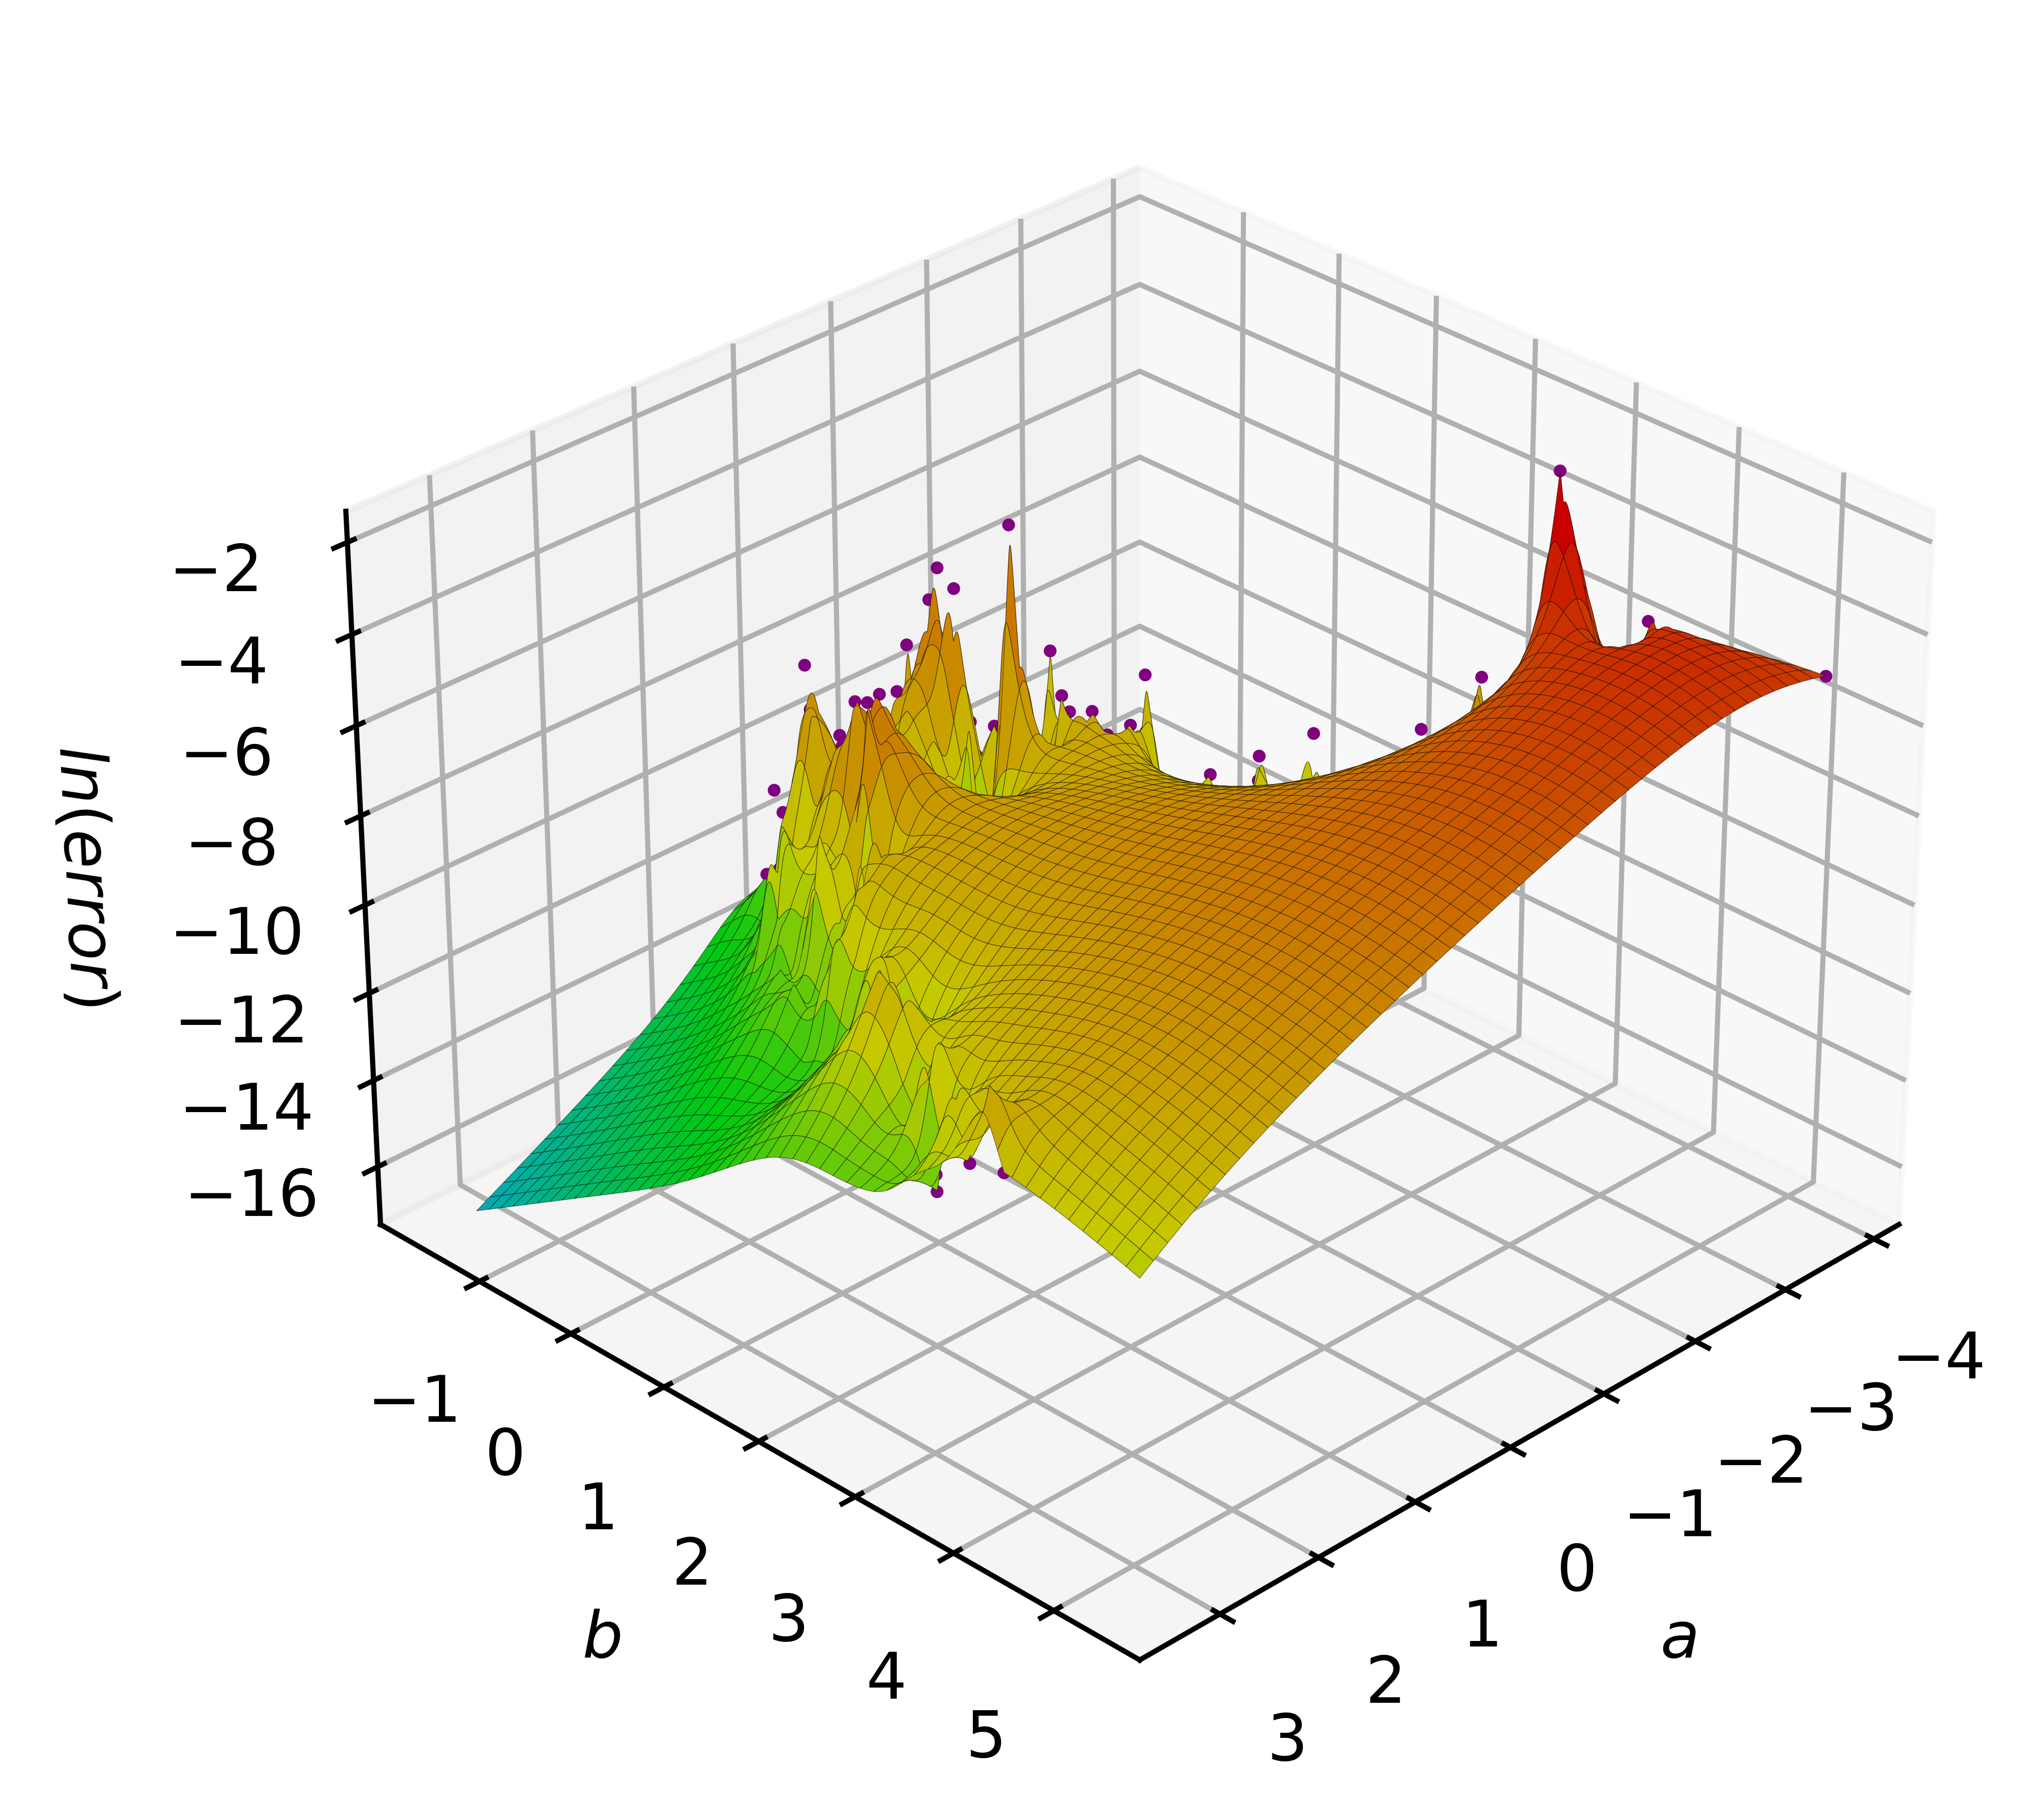

In [150]:
#plot_3d_surface(a_arr, b_arr, relErr, '$a$', '$b$', 0.1, 45, 30)

Aza
1000


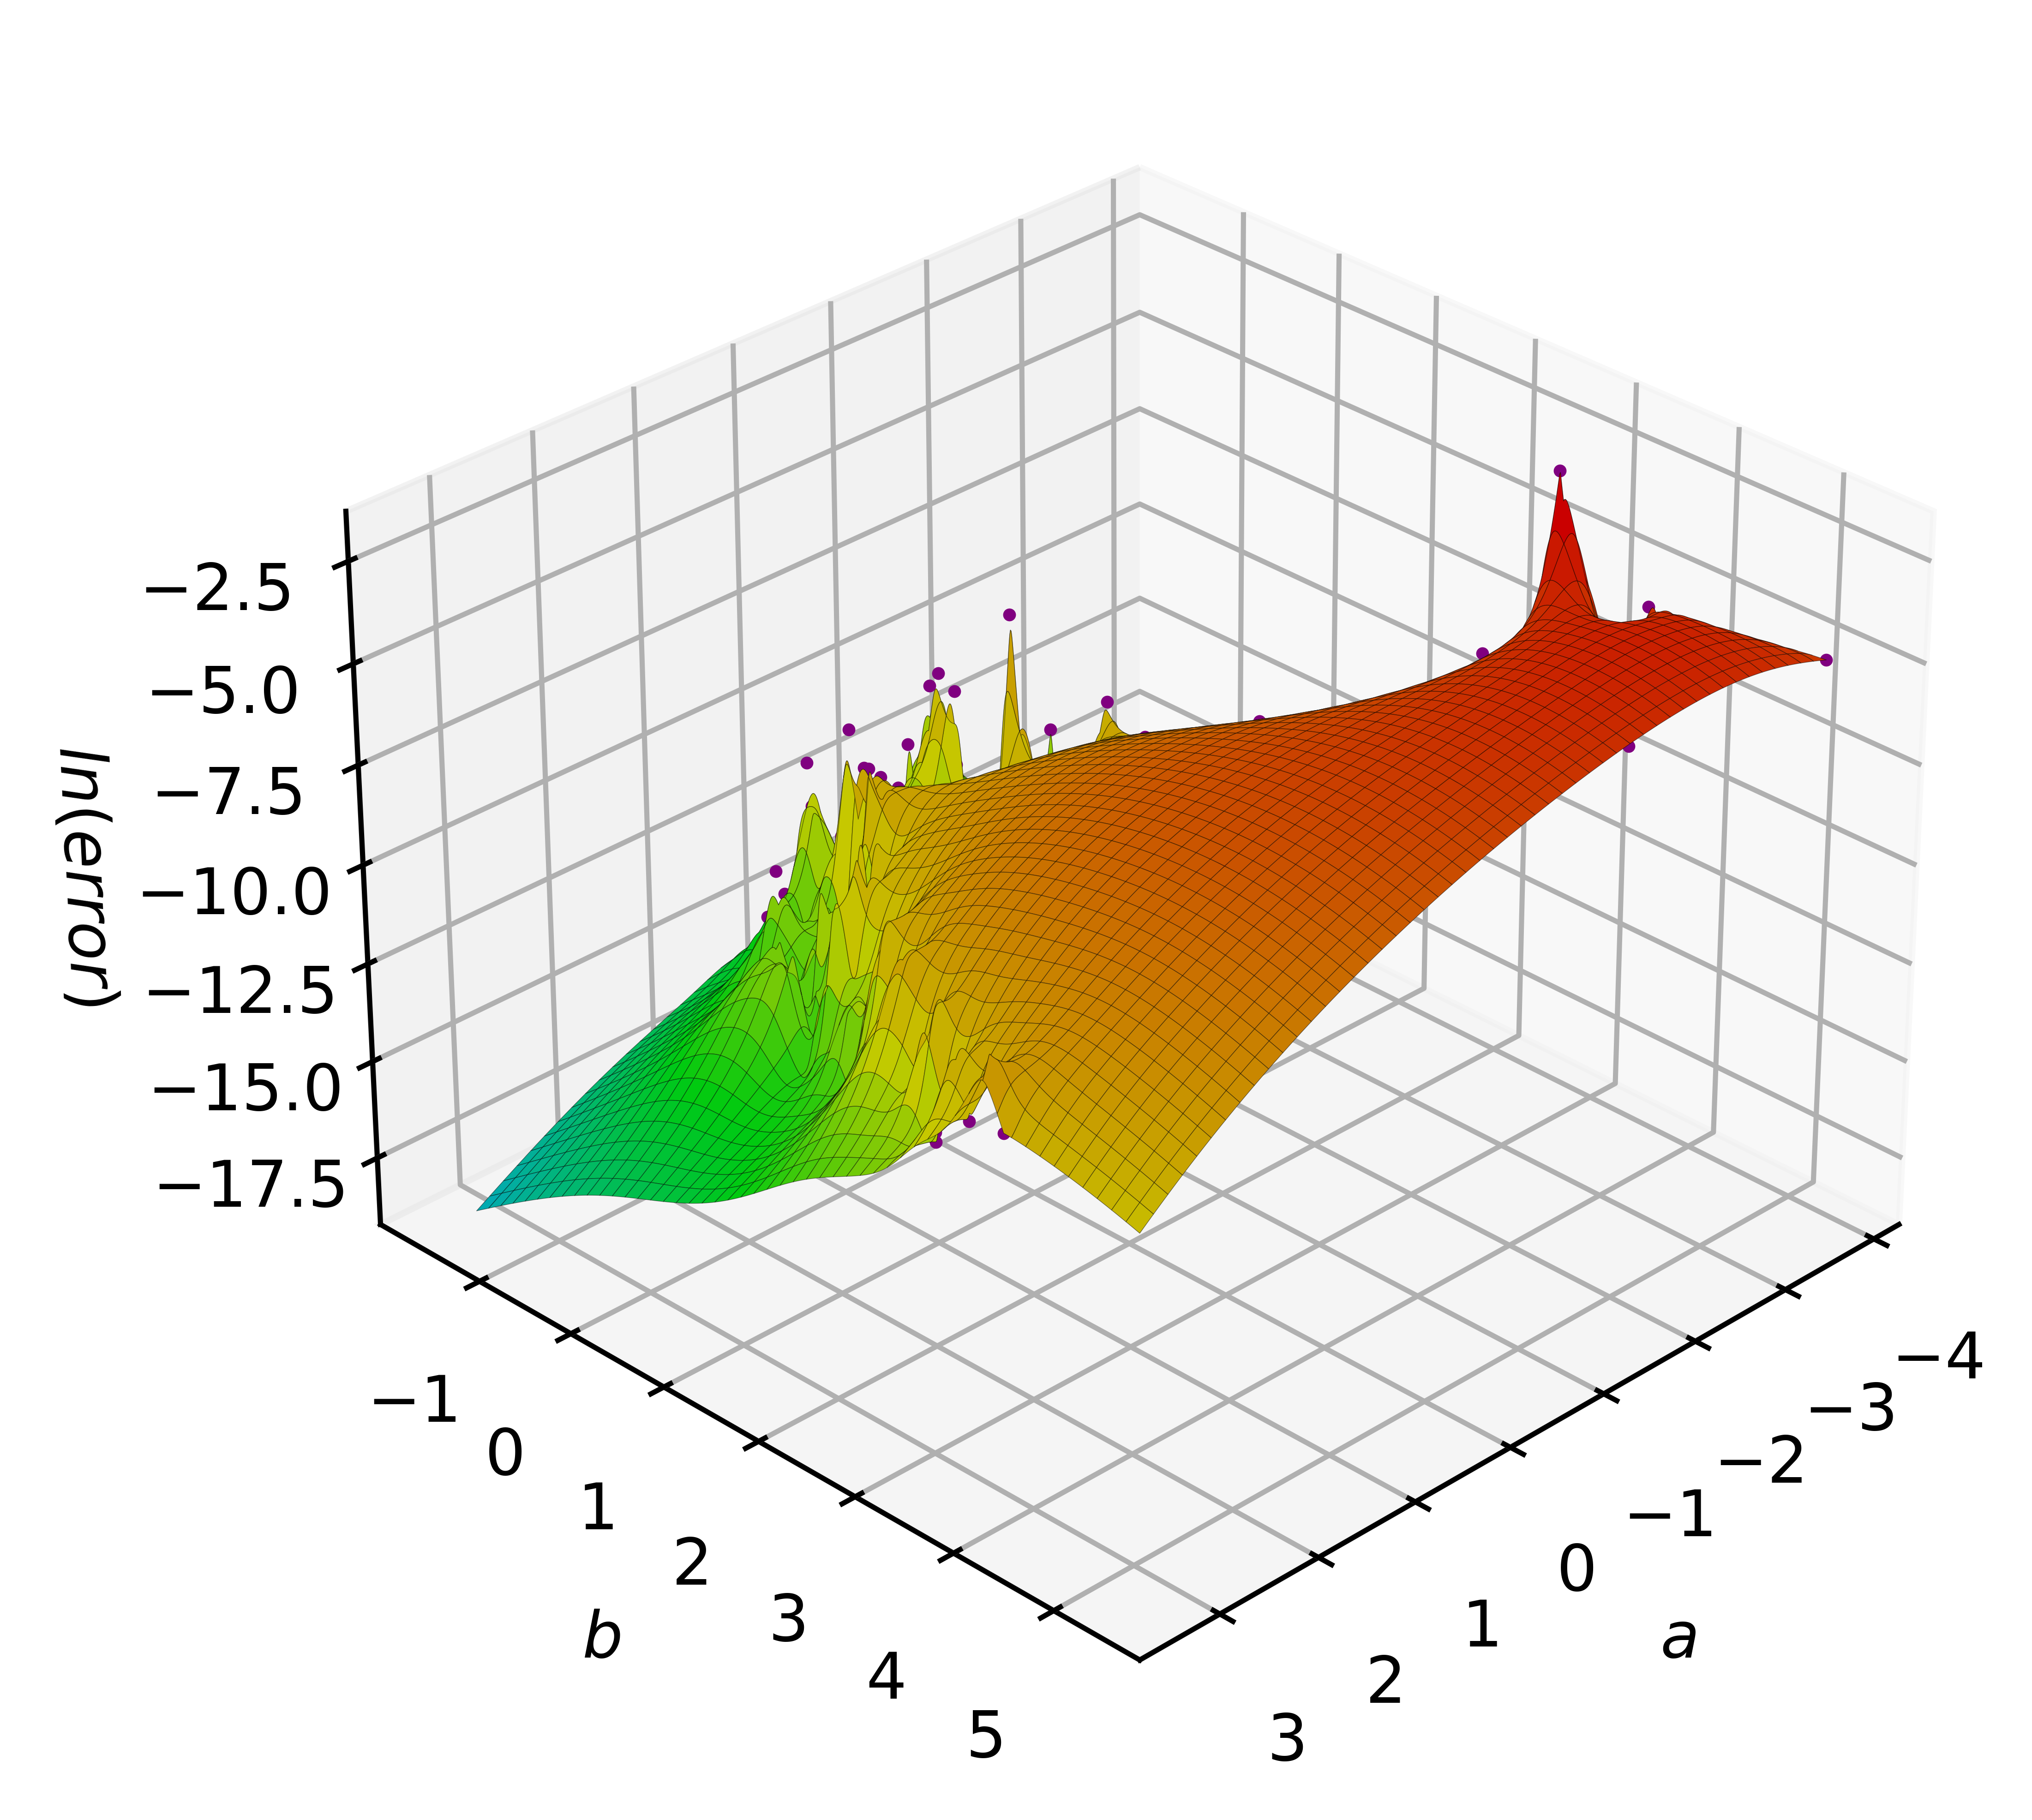

In [161]:
#plot_3d_surface(a_arr, b_arr, relErr, '$a$', '$b$', 0.1, 45, 30)

193


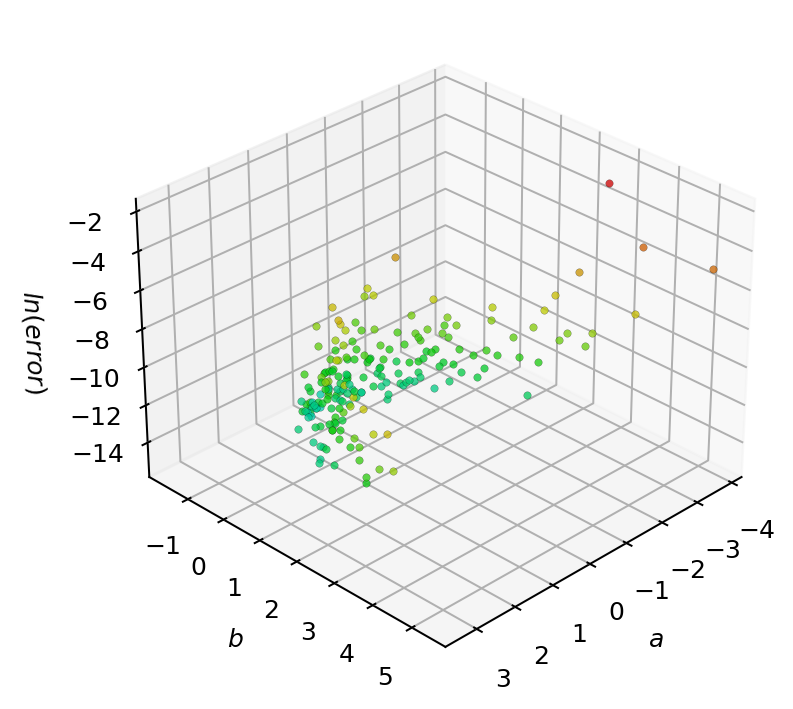

In [167]:
#plot_surface(a_arr, b_arr, relErr, '$a$', '$b$', 0.1, 45, 30)

In [134]:
def CBRT(x):
    cbrt = sp.cbrt(x)
    
    root1 = cbrt
    root2 = cbrt * sp.exp(TWO * sp.I * sp.pi * ONE_THIRD)  # Дополнительные корни
    root3 = cbrt * sp.exp(FOUR * sp.I * sp.pi * ONE_THIRD)
    
    return [root1.evalf(), root2.evalf(), root3.evalf()]

In [125]:
def cond_4_10(betta0CubeRoots, gamma0CubeRoots, Q):
    min_rr = np.inf
    min_r = np.inf
    indexB = -1
    indexG = -1
    
    for i in range(3):
        tmpB = betta0CubeRoots[i]
        for j in range(3):
            tmpG = gamma0CubeRoots[j]
            BG = tmpB * tmpG
            if(abs(im(BG)) <= min_rr):
                min_rr = abs(im(BG))
                if (abs(re(BG) - Q) <= min_r):
                    min_r = abs(re(BG) - Q)
                    indexB = i
                    indexG = j
                    break
            #print("B*G = ", BG)
            #print("Q = ", Q)
            #print(i, ' ', j)
            #if abs((BG - Q).evalf()) <= 10**(-acc*ONE_HALF):
            #    return i, j
            
    return indexB, indexG

In [27]:
def cond_4_11(bettaSqrts, gammaSqrts, deltaSqrts, P):
    min_r1 = np.inf
    min_r2 = np.inf
    
    indexB = -1
    indexG = -1
    indexD = -1

    for i in range(2):
        tmpB = bettaSqrts[i]
        for j in range(2):
            tmpG = gammaSqrts[j]
            for k in range(2):
                tmpD = deltaSqrts[k]
                #print(tmpB.evalf(8))
                #print(tmpG.evalf(8))
                #print(tmpD.evalf(8))
                BGD = tmpB * tmpG * tmpD
                
                if abs(re(BGD) + P) <= min_r1 and im(BGD) <= min_r2:
                    min_r1 = abs(re(BGD) + P)
                    min_r2 = im(BGD)
                    indexB = i
                    indexG = j
                    indexD = k
                    #print(indexB, indexG, indexD, min_r1, min_r2)
                    #print(min_r1, min_r2)
                    #print("----------")
                    break
                #print("B*G*D = ", BGD)
                #print("Q = ", P)
                #print(i, ' ', j)
                #if abs((BGD - P).evalf()) <= 10**(-acc*ONE_HALF):
                #    return i, j, k
            
    return indexB, indexG, indexD